<a href="https://colab.research.google.com/github/rsharanesh/shara/blob/master/Final_Feature_modelling_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES**

In [1]:
import numpy as np 
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Getting the data

I have mounted my drive and all the files are being in the folder of Analytic_club_competition in my google drive.

In [0]:
#Getting the training and testing data sets
given_train_data=pd.read_csv("/content/drive/My Drive/Analytic_club_competition/train.csv") 
given_pred_data=pd.read_csv("/content/drive/My Drive/Analytic_club_competition/test.csv")

y_train=given_train_data['price']#seperating the target variable

In the following we are observing the datasets and their features. We are then dropping the 'id' column which is of no use and we are storing them in a seperate file.

In [3]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(given_train_data.shape))
print("The test data size before dropping Id feature is : {} ".format(given_pred_data.shape))

# Save the 'Id' column
train_ID = given_train_data['id']
pred_ID = given_pred_data['id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
given_train_data.drop("id", axis = 1, inplace = True)
given_pred_data.drop("id", axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(given_train_data.shape)) 
print("The test data size after dropping Id feature is : {} ".format(given_pred_data.shape))

The train data size before dropping Id feature is : (17210, 19) 
The test data size before dropping Id feature is : (4210, 18) 

The train data size after dropping Id feature is : (17210, 18) 
The test data size after dropping Id feature is : (4210, 17) 


 **FEATURE ENGINEERING**

Now lets dive into the important step which is the one that drastically improves our results. So now lets just have a look at the training dataset by using the describe method.

In [4]:
given_train_data.describe()

,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.721000e+04,17210.000000,17210.000000,1.721000e+04,17210.000000,17210.000000,17210.000000,17210.000000,17210.000000,17210.000000,17210.000000,17210.000000,17210.000000,17210.000000,17210.000000,17210.000000,17210.000000
mean,5.391069e+05,3.373213,2080.172051,1.513545e+04,1.498605,0.008077,3.409587,7.661941,1788.108077,292.063974,1971.285880,84.305985,98077.903661,47.559731,-122.213991,1987.480244,12785.612028
std,3.674218e+05,0.927616,917.995097,4.260361e+04,0.542192,0.089509,0.646909,1.170044,824.994890,443.397892,29.378191,401.454725,53.554500,0.138973,0.140486,684.866281,27294.470122
min,7.800000e+04,1.000000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,3.200000e+05,3.000000,1420.000000,5.034000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1952.000000,0.000000,98033.000000,47.468925,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,1910.000000,7.620000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,6.400000e+05,4.000000,2550.000000,1.070075e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678175,-122.125000,2368.250000,10092.000000
max,7.700000e+06,33.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


**Adding New Features**


---
We see that there are few features which can't be used very much explicitly and hence we need to modify them.Now lets just add some more features using those existing features.


1.Using the date

---
We see that the date column is been featured as an object type and so we can't use it explictly and so make a sense of it we can seperate of the year, month, date and day of the week from the date object and add them as indivual feature to our dataset.


In [0]:
# we use the datetimeindex method to retrive the date,day,month,year seperately from the date object
given_train_data['year_sale'] = pd.DatetimeIndex(given_train_data['date']).year
given_pred_data['year_sale'] = pd.DatetimeIndex(given_pred_data['date']).year

given_train_data['month_sale'] = pd.DatetimeIndex(given_train_data['date']).month
given_pred_data['month_sale'] = pd.DatetimeIndex(given_pred_data['date']).month

given_train_data['date_sale'] = pd.DatetimeIndex(given_train_data['date']).day
given_pred_data['date_sale'] = pd.DatetimeIndex(given_pred_data['date']).day

given_train_data['day_sale'] = pd.DatetimeIndex(given_train_data['date']).weekday
given_pred_data['day_sale'] = pd.DatetimeIndex(given_pred_data['date']).weekday

2.Combing the areas

---
Looking at the decription of the dataset we observe that there are many areas of the land and the house that are mentioned seperately in the dataset.
So we do some sort of enhancement and get the area that includes the building and the free area that is been free of buildings.

This is done on the general assumption that mostly houses with free area have ceratain ascribed value.


In [0]:
given_train_data['land_area']=given_train_data['sqft_above']+given_train_data['sqft_basement']
given_pred_data['land_area']=given_pred_data['sqft_above']+given_pred_data['sqft_basement']

given_train_data['house_area']=given_train_data['sqft_living']+given_train_data['sqft_lot']
given_pred_data['house_area']=given_pred_data['sqft_living']+given_pred_data['sqft_lot']

given_train_data['house_area15']=given_train_data['sqft_living15']+given_train_data['sqft_lot15']
given_pred_data['house_area15']=given_pred_data['sqft_living15']+given_pred_data['sqft_lot15']

given_train_data['free_area']=given_train_data['sqft_lot']-given_train_data['sqft_basement']
given_pred_data['free_area']=given_pred_data['sqft_lot']-given_pred_data['sqft_basement']

given_train_data['free_area15']=given_train_data['sqft_lot15']-given_train_data['sqft_basement']
given_pred_data['free_area15']=given_pred_data['sqft_lot15']-given_pred_data['sqft_basement']

3.Bedroom area and Floor area

---
Adding to our list of features, we include the indivual bedroom area and the indivual floor area by diving the house area respectively with the number of bedrooms and the number of floors.

Even here I make an explicit assumption that all the floors and bedrooms are of equal sizes.


In [0]:
given_train_data['bed_area']=given_train_data['sqft_living']/given_train_data['bedrooms']
given_pred_data['bed_area']=given_pred_data['sqft_living']/given_pred_data['bedrooms']

given_train_data['floor_area']=given_train_data['sqft_living']/given_train_data['floors']
given_pred_data['floor_area']=given_pred_data['sqft_living']/given_pred_data['floors']

Now after adding few new features lets have a look at our dataset again.

In [8]:
given_train_data.head()

,date,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sale,month_sale,date_sale,day_sale,land_area,house_area,house_area15,free_area,free_area15,bed_area,floor_area
0,10/13/2014,221900.0,3,1180,5650,1.0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13,0,1180,6830,6990,5650,5650,393.333333,1180.0
1,12/9/2014,538000.0,3,2570,7242,2.0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9,1,2570,9812,9329,6842,7239,856.666667,1285.0
2,2/25/2015,180000.0,2,770,10000,1.0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25,2,770,10770,10782,10000,8062,385.000000,770.0
3,12/9/2014,604000.0,4,1960,5000,1.0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9,1,1960,6960,6360,4090,4090,490.000000,1960.0
4,2/18/2015,510000.0,3,1680,8080,1.0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18,2,1680,9760,9303,8080,7503,560.000000,1680.0


Now lets drop the date column which is of the type 'object' which isn't going to make any sense in the modelling and prediction process.

In [0]:
train=given_train_data.drop(columns=['date'])
test=given_pred_data.drop(columns=['date'])

Finding the Correlation Matrix

---
After Adding these new featues lets have a look at the correlation matrix.


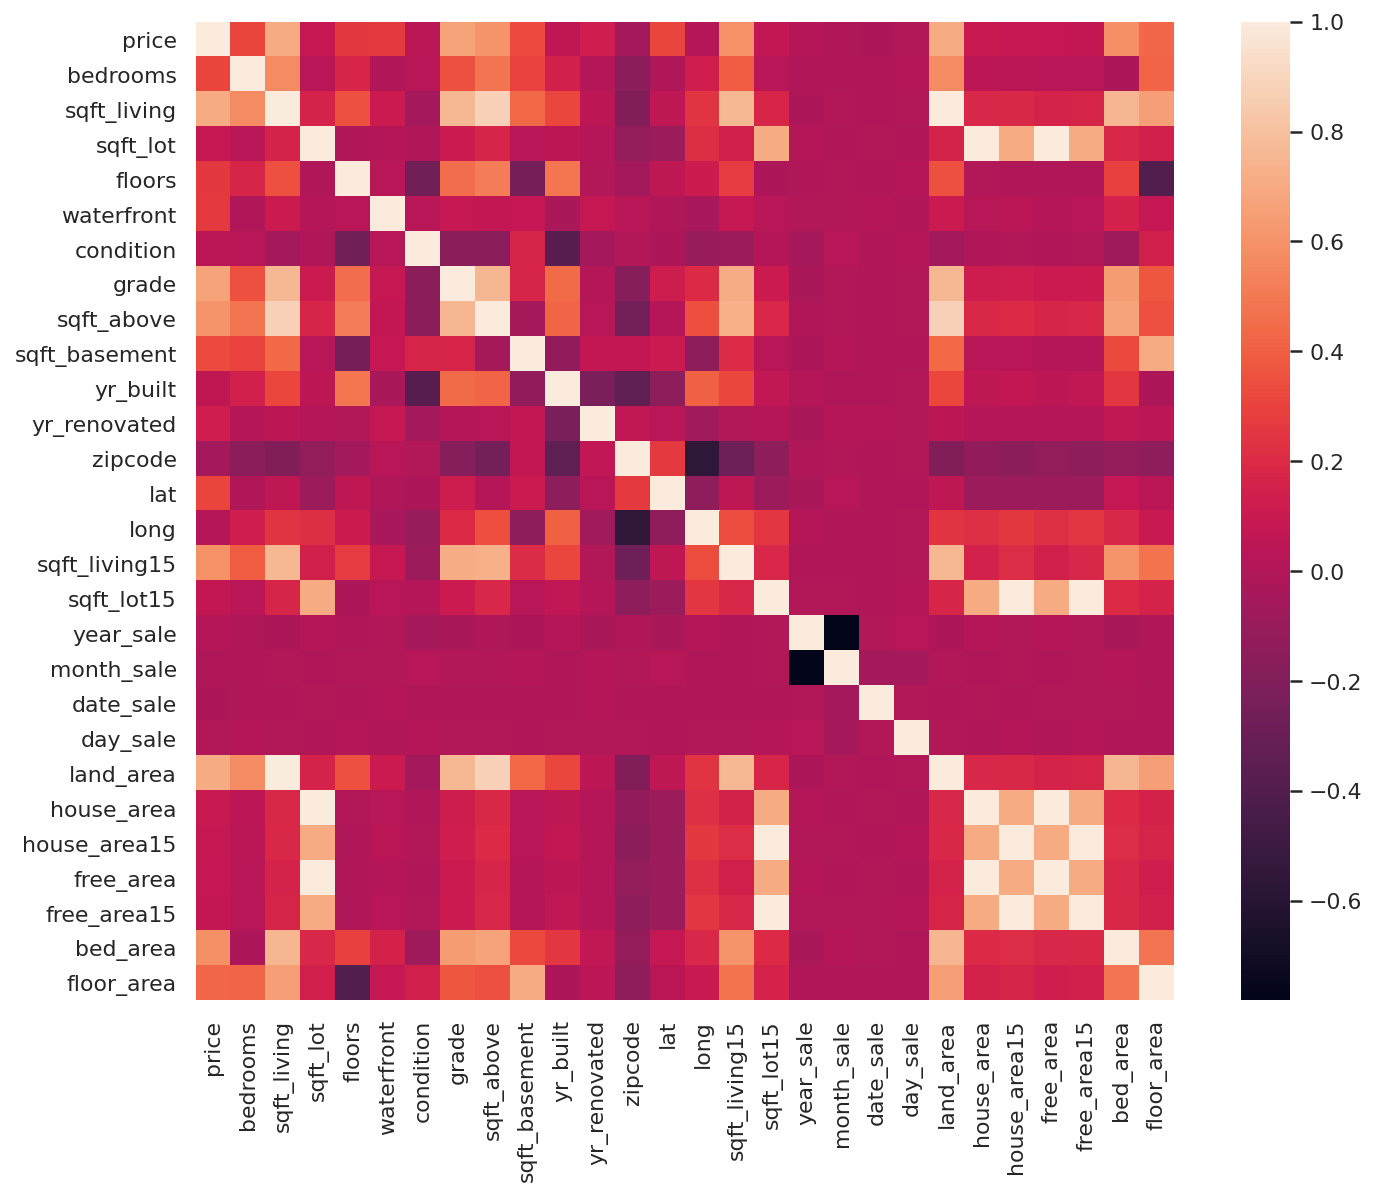

In [10]:
corrmat=train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

In [11]:
corrmat['price']

price            1.000000
bedrooms         0.305478
sqft_living      0.702767
sqft_lot         0.083500
floors           0.258149
waterfront       0.266806
condition        0.035774
grade            0.672084
sqft_above       0.605709
sqft_basement    0.327989
yr_built         0.053682
yr_renovated     0.126069
zipcode         -0.052560
lat              0.307796
long             0.017730
sqft_living15    0.590577
sqft_lot15       0.073874
year_sale        0.005184
month_sale      -0.010287
date_sale       -0.018009
day_sale        -0.001857
land_area        0.702767
house_area       0.098272
house_area15     0.088261
free_area        0.080098
free_area15      0.068565
bed_area         0.583076
floor_area       0.430681
Name: price, dtype: float64

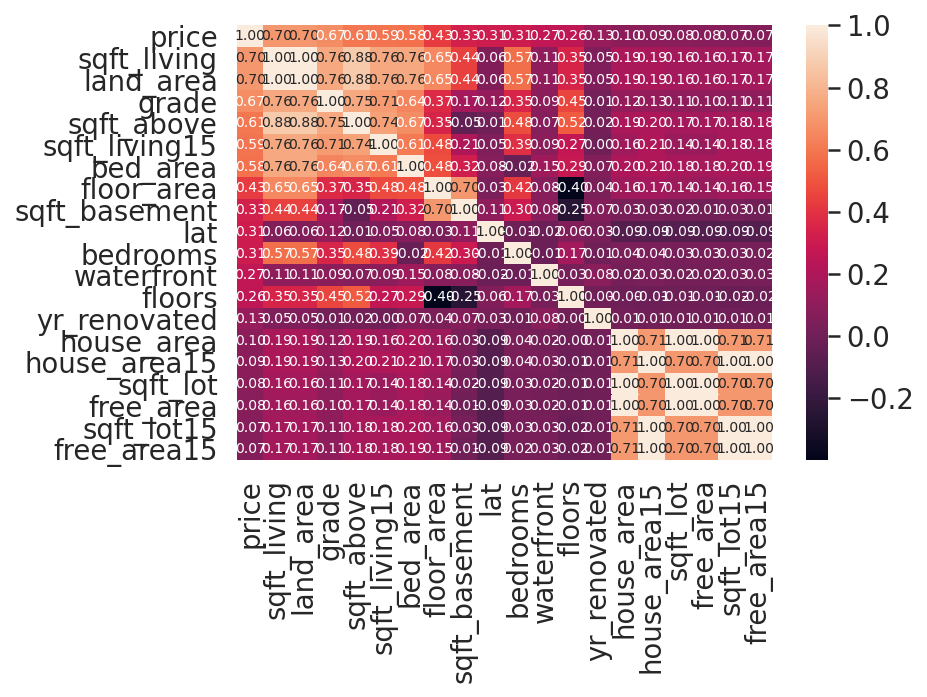

In [12]:
# Top 20 Heatmap
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=False, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [13]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,price
1,sqft_living
2,land_area
3,grade
4,sqft_above
5,sqft_living15
6,bed_area
7,floor_area
8,sqft_basement
9,lat


**Existing Feature Analysis**

---
Now after adding certain features to our dataset and having a look at the correlation matrix, I now do the indivudual feature against the target variable.



 mu = 539106.85 and sigma = 367411.11



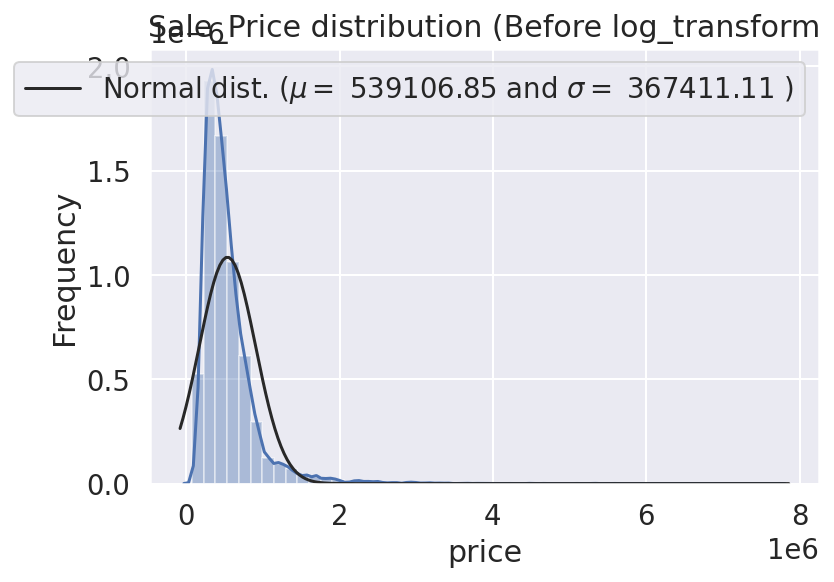

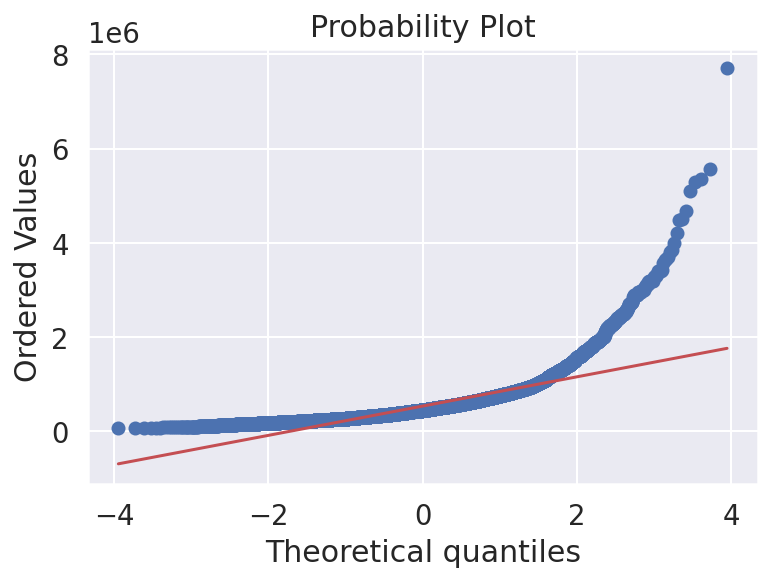

Skewness: 3.821753
Kurtosis: 29.659426


In [14]:
# Plot Histogram for price
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale_Price distribution (Before log_transform')

fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())


The targert variable more or less looks similar to that of a normal distribution.Looking at the kurtosis score, we can see that there is a very nice peak. However, looking at the skewness score, we can see that the sale prices deviate from the normal distribution. In order to fix this we will now take the log_transform of the target_variable and then have a look at distribution.

Taking the log_transform for price

In [0]:
train['log_price'] =  np.log1p(train['price']) # here we take the log tranform for the target variable which is price here


 mu = 13.04 and sigma = 0.53



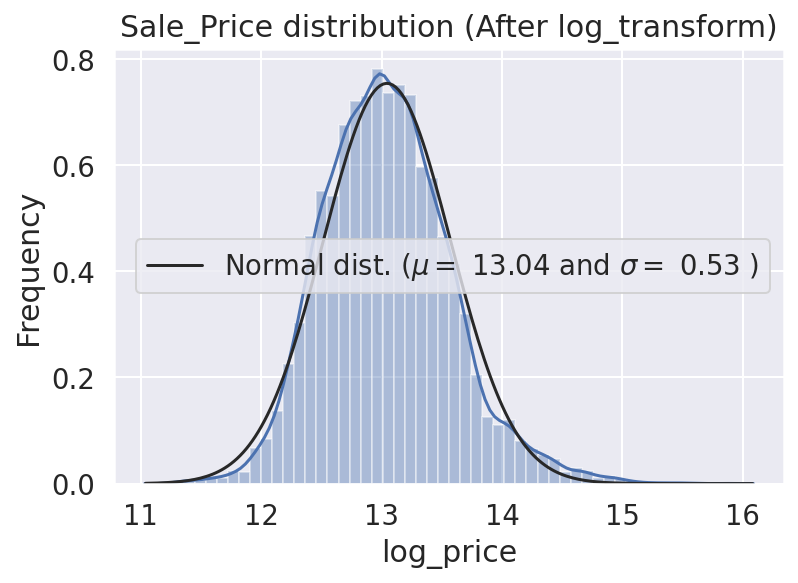

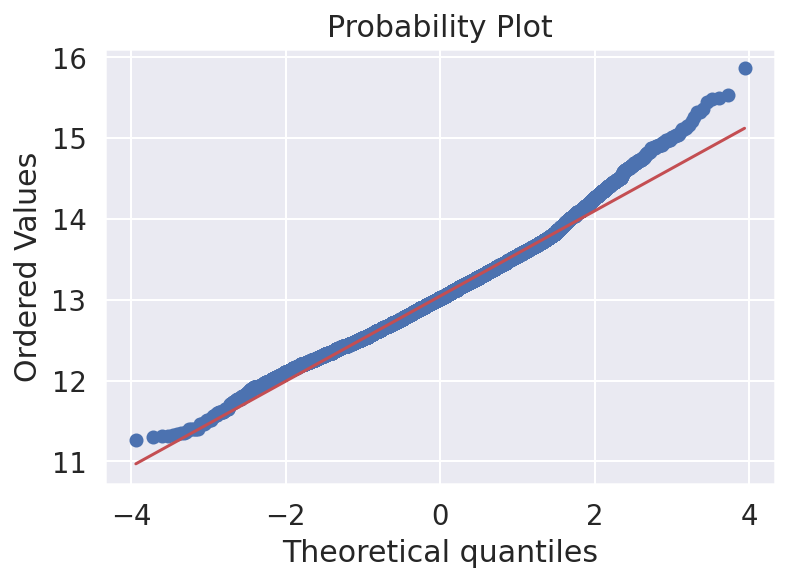

Skewness: 0.436329
Kurtosis: 0.691758


In [16]:
# Plot Histogram for log_price
sns.distplot(train['log_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['log_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale_Price distribution (After log_transform)')

fig = plt.figure()
res = stats.probplot(train['log_price'], plot=plt)
plt.show()

print("Skewness: %f" % train['log_price'].skew())
print("Kurtosis: %f" % train['log_price'].kurt())

Hurray!!! Now after applying log transform to our target variable we could now see that the distribution is very much similar to that of a perfect normal distribution. This could confirmed by looking at the Skewness and the Kurtosis Scores before and after taking the log tansforms. 

**Indivudaul Feature Relations**
(From the Most_Correlated_Features against the target variable)

---
Let's check out all the variables! There are two types of features in housing data, categorical and numerical.

Categorical data is just like it sounds. It is in categories. It isn't necessarily linear, but it follows some kind of pattern.

Numerical data is data in number form. Plain and simple. Simple and clean.

For Categorical data visualise the relationship in terms of boxplots and on the other for Numerical data we use the method of jointplot.

1.Sqft_Living (Numerical Variable)

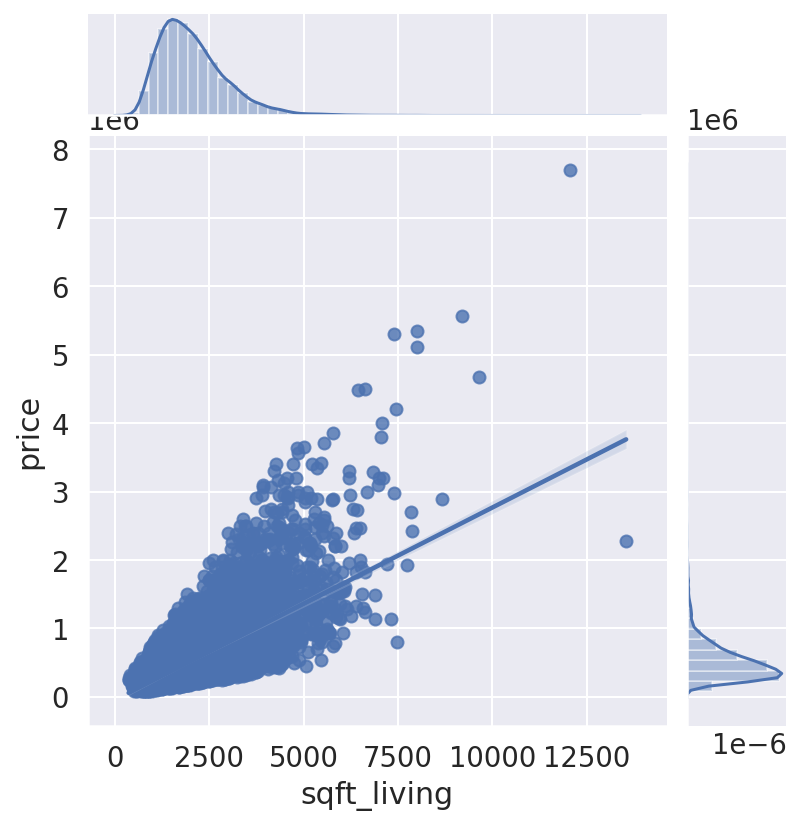

In [17]:
# Living Area vs Sale_Price (Before_removing the Outliers)
sns.jointplot(x=train['sqft_living'], y=train['price'], kind='reg') # it is continous numerical variable

From the above plot it makes sense that people would pay for the more living area. But the point that doen't make sense is the datapoint in the bottom-right of the plot.

To deal with it we will remove them so called outliers manually.

In [0]:
# Removing outliers manually (One point in the bottom right)
train = train.drop(train[(train['sqft_living']>10000) 
                         & (train['price']<3000000)].index).reset_index(drop=True)

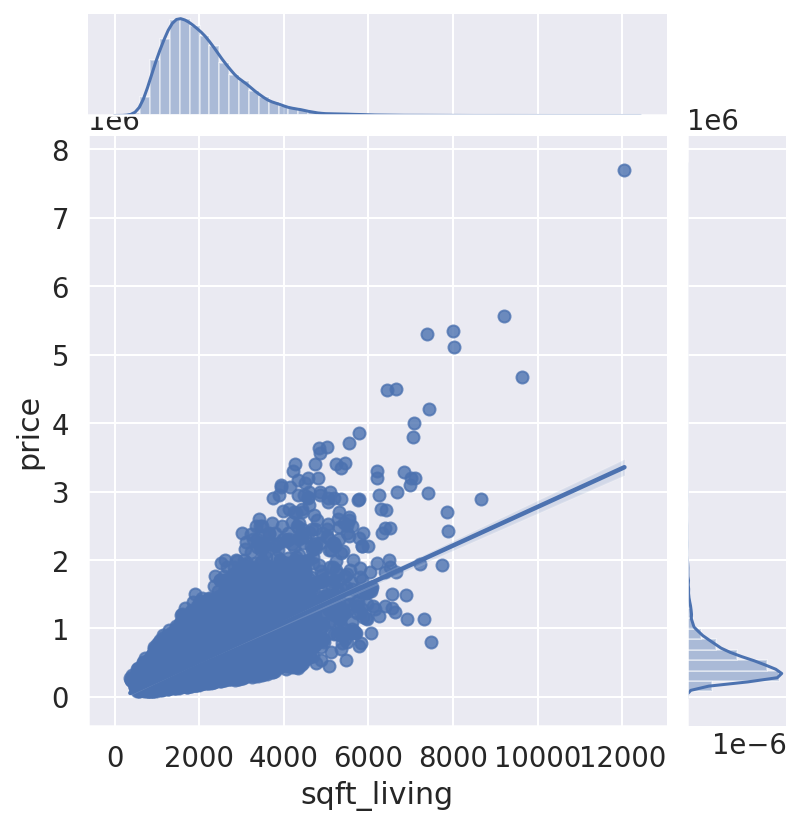

In [19]:
# Living Area vs Sale_Price (After_removing the Outliers)
sns.jointplot(x=train['sqft_living'], y=train['price'], kind='reg') ##it is continous numerical variable

2.land_area (Numerical Variable)

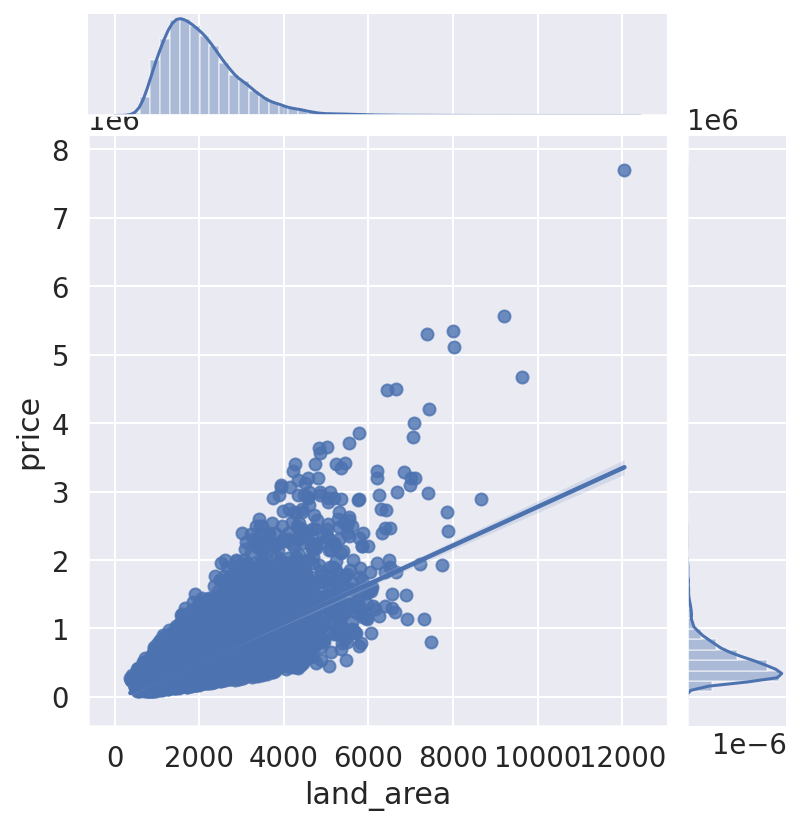

In [20]:
# Total Land Area vs Sale_Price (Before removing the outlier)
sns.jointplot(x=train['land_area'], y=train['price'], kind='reg') ##it is continous numerical variable

In this there are no outliers

3.grade (Categorical Variable)

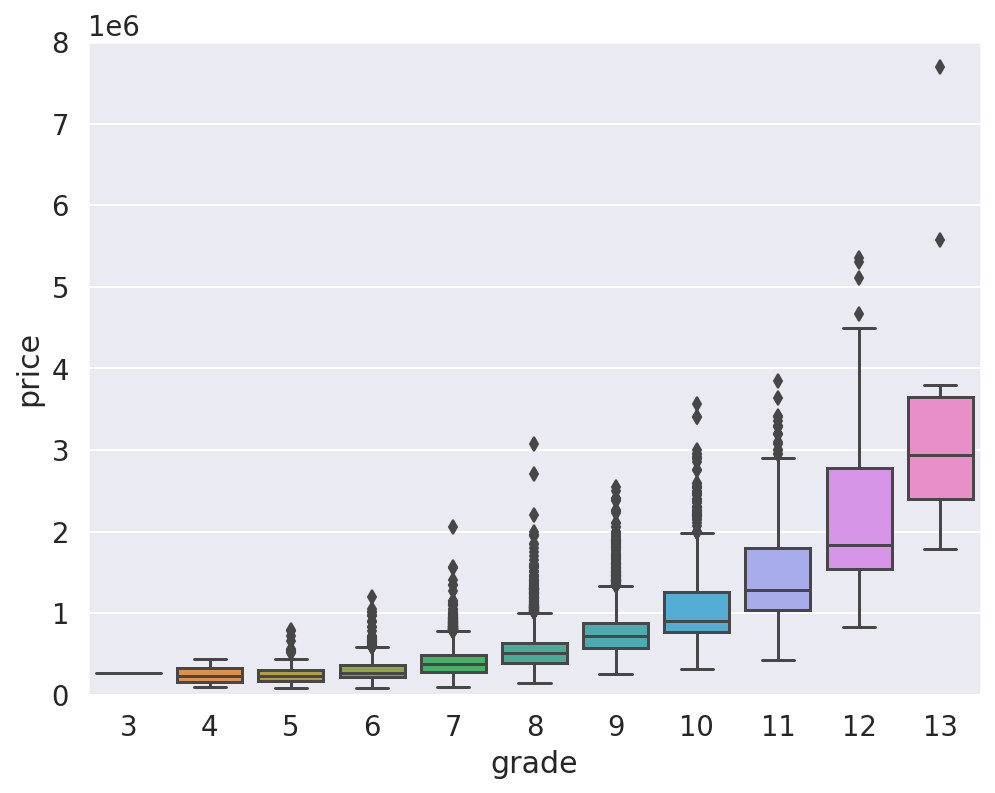

In [21]:
# Grade Quality vs Sale Price
var = 'grade'
data = pd.concat([train['price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);

Even this case isnt suprising becaue people usually pay more for high quality houses and hence there aren't any outliers in this case.

4.sqft_above (Numerical Variable)

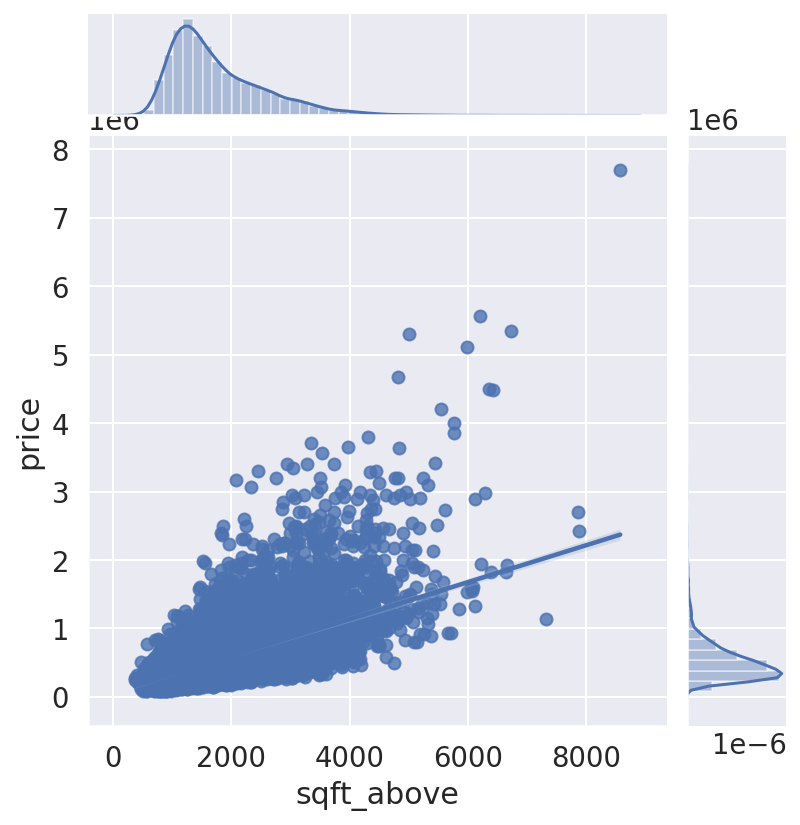

In [22]:
# Area Above vs Sale_Price (Before removing the outliers)
sns.jointplot(x=train['sqft_above'], y=train['price'], kind='reg')

By looking at the plot we could see that people pay more for more area of the flat. But we do have an outlier in this case the one point in the bottom right 
So again here we remove it manually.

In [0]:
# Removing outliers manually (One point in the bottom right)
train = train.drop(train[(train['sqft_above']>7000) 
                         & (train['price']<2000000)].index).reset_index(drop=True)

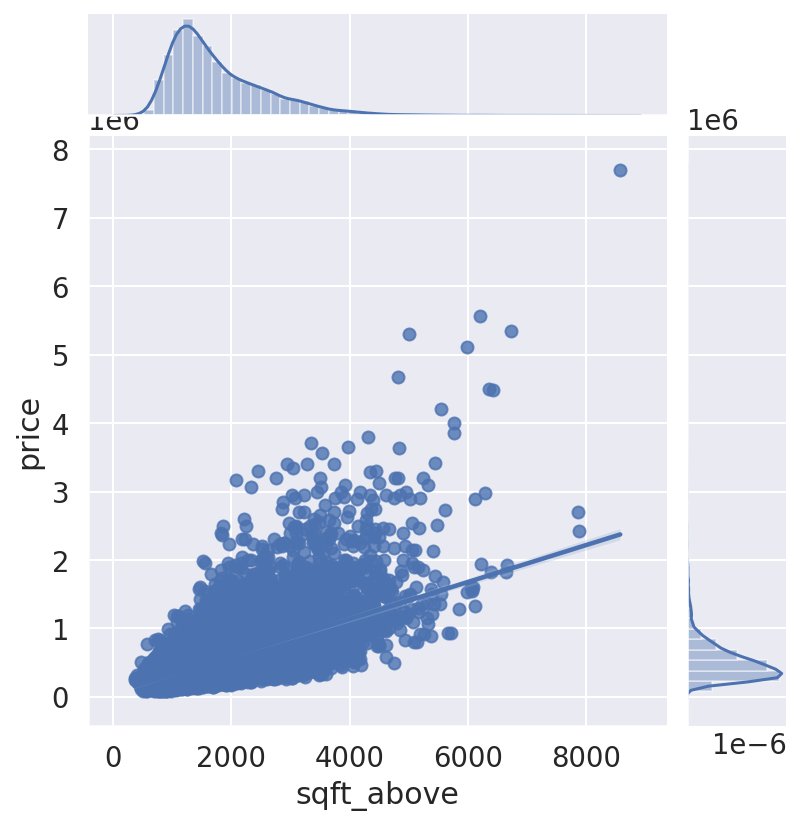

In [24]:
# Area Above vs Sale Price (After removing the outliers)
sns.jointplot(x=train['sqft_above'], y=train['price'], kind='reg')

5.sqft_living15 (Numerical variable)

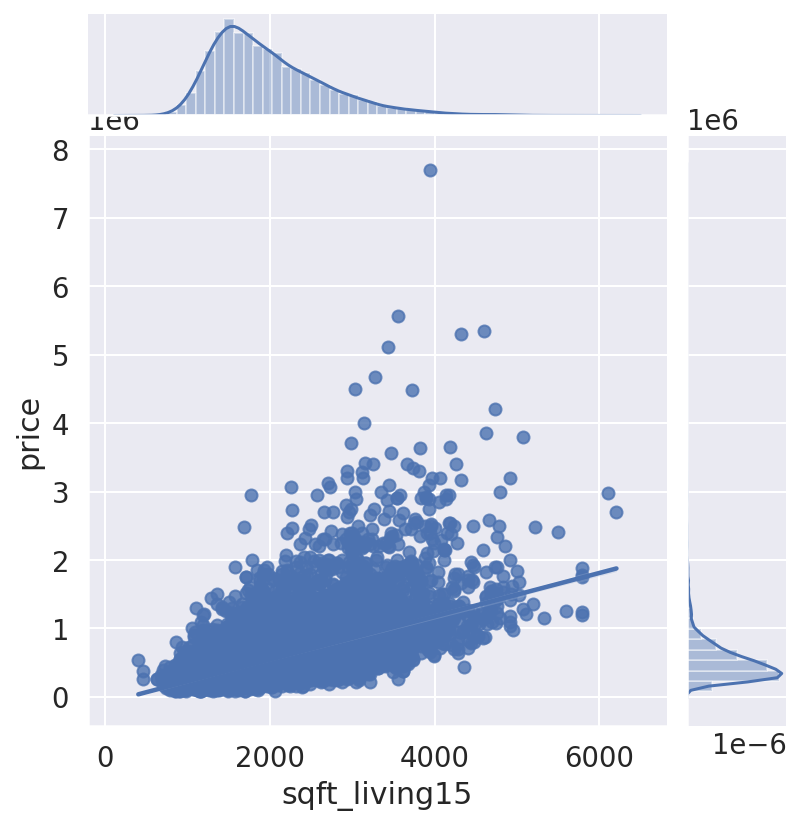

In [25]:
# Living Area_2015 vs Sale Price (Before removing the outliers)
sns.jointplot(x=train['sqft_living15'], y=train['price'], kind='reg')

The same case of outlier even exist here and we do remove them manually.

In [0]:
# Removing outliers manually (few points in the bottom right)
train = train.drop(train[(train['sqft_living15']>5000) 
                         & (train['price']<1500000)].index).reset_index(drop=True)

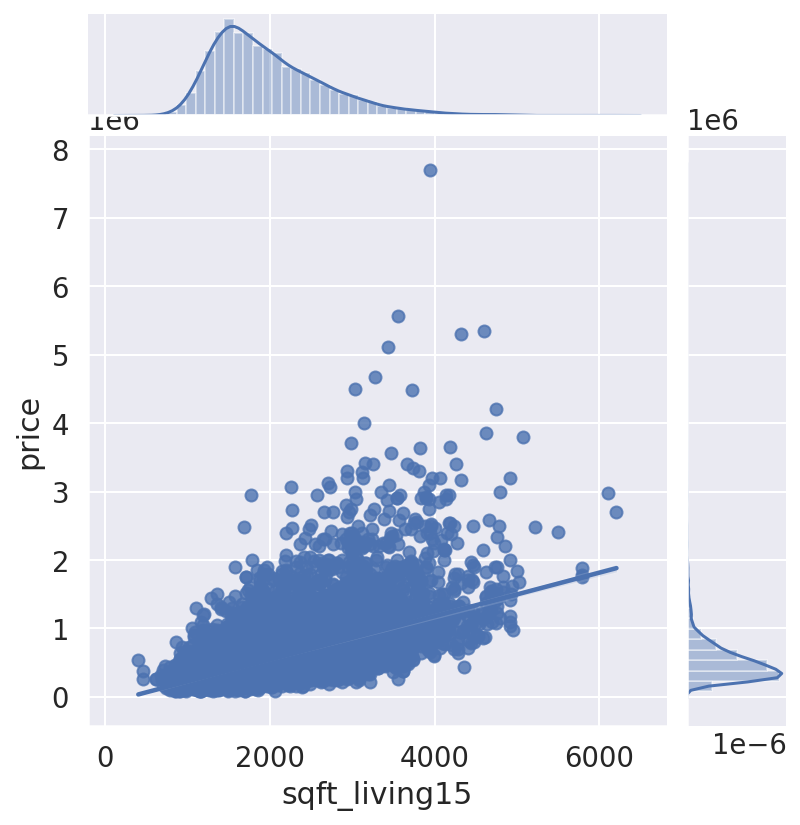

In [27]:
# Living Area_2015 vs Sale Price (After Removing the Outliers)
sns.jointplot(x=train['sqft_living15'], y=train['price'], kind='reg')

6.bed_area (Numerical Variable)

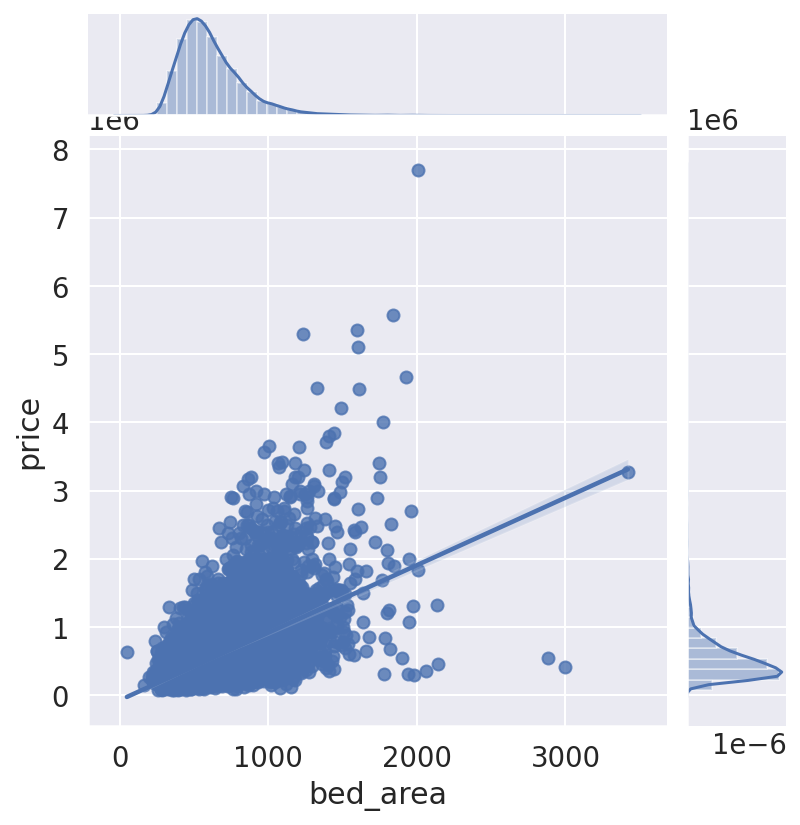

In [28]:
# Bedroom Area vs Sale Price (Before removing the outlier)
sns.jointplot(x=train['bed_area'], y=train['price'], kind='reg')

Again with the bottom two data-points. Let's remove those outliers.

In [0]:
# Removing outliers manually (few points in the bottom right)
train = train.drop(train[(train['bed_area']>1750) 
                         & (train['price']<1800000)].index).reset_index(drop=True)

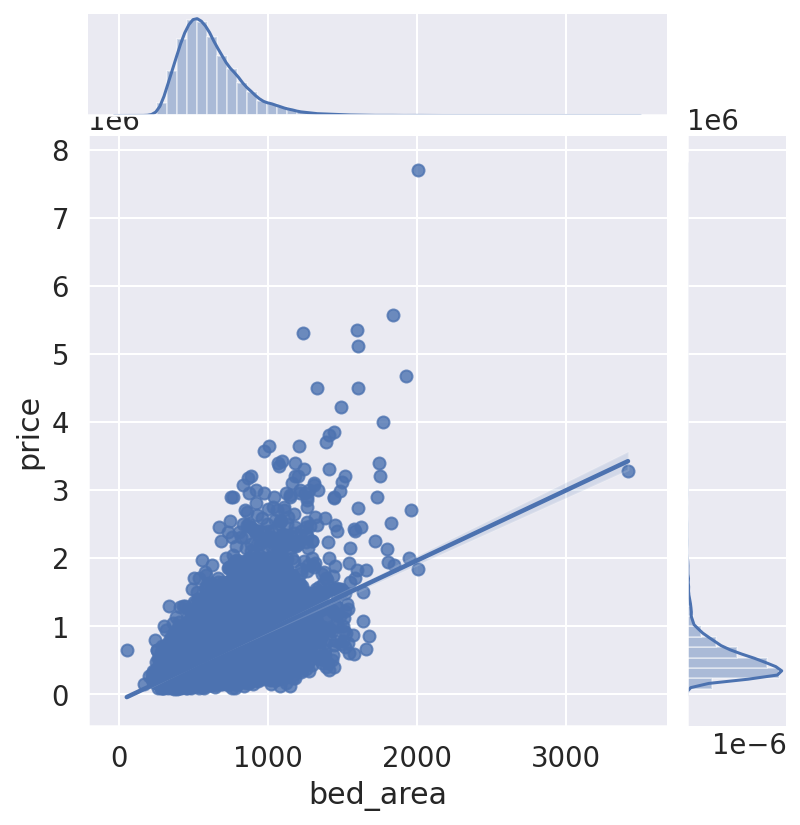

In [30]:
# Bedroom Area vs Sale Price (After removing the Outliers)
sns.jointplot(x=train['bed_area'], y=train['price'], kind='reg')

7.floor_area (Numerical variable)

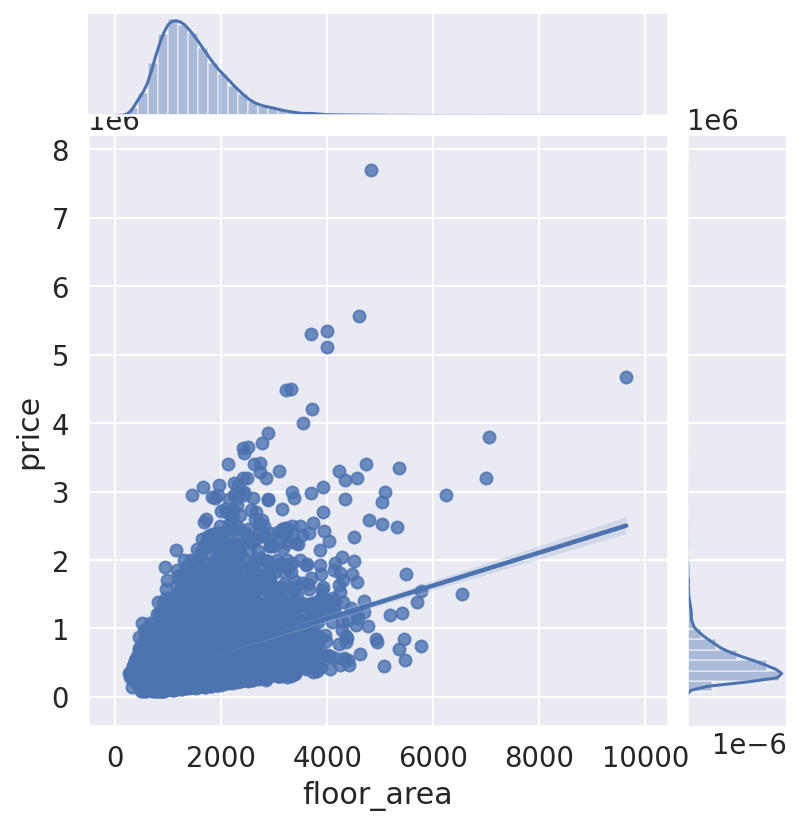

In [31]:
# Floor Area vs Sale Price
sns.jointplot(x=train['floor_area'], y=train['price'], kind='reg')

Here too exits few outliers and we do remove them manually.

In [0]:
# Removing outliers manually (One point in the bottom right)
train = train.drop(train[(train['floor_area']>4700) 
                         & (train['price']<1700000)].index).reset_index(drop=True)

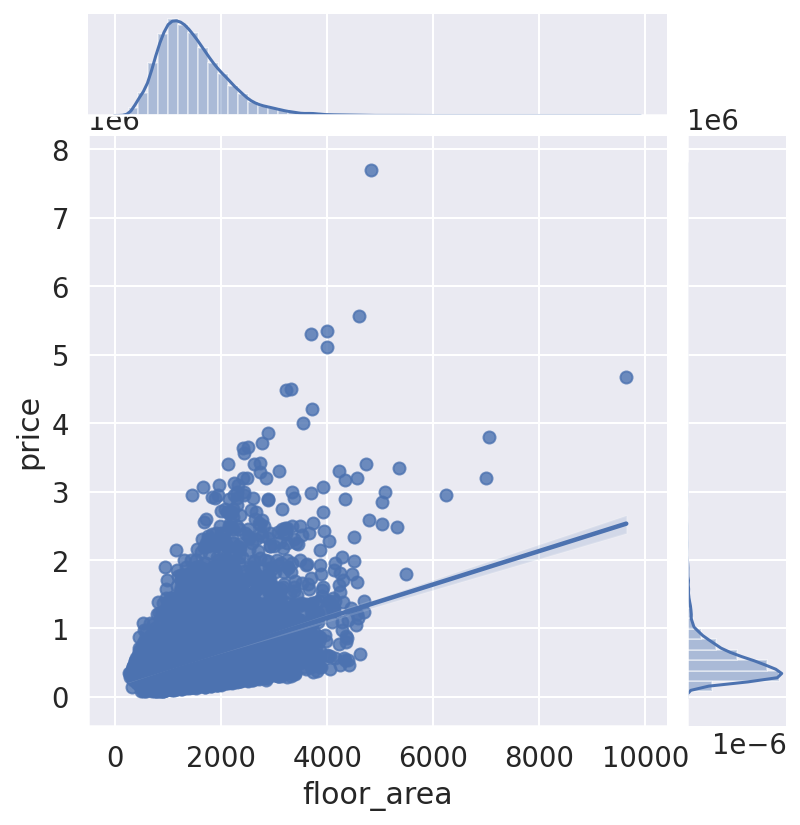

In [33]:
# Floor Area vs Sale Price (after)
sns.jointplot(x=train['floor_area'], y=train['price'], kind='reg')

8.sqft_basement (Numerical Variable)

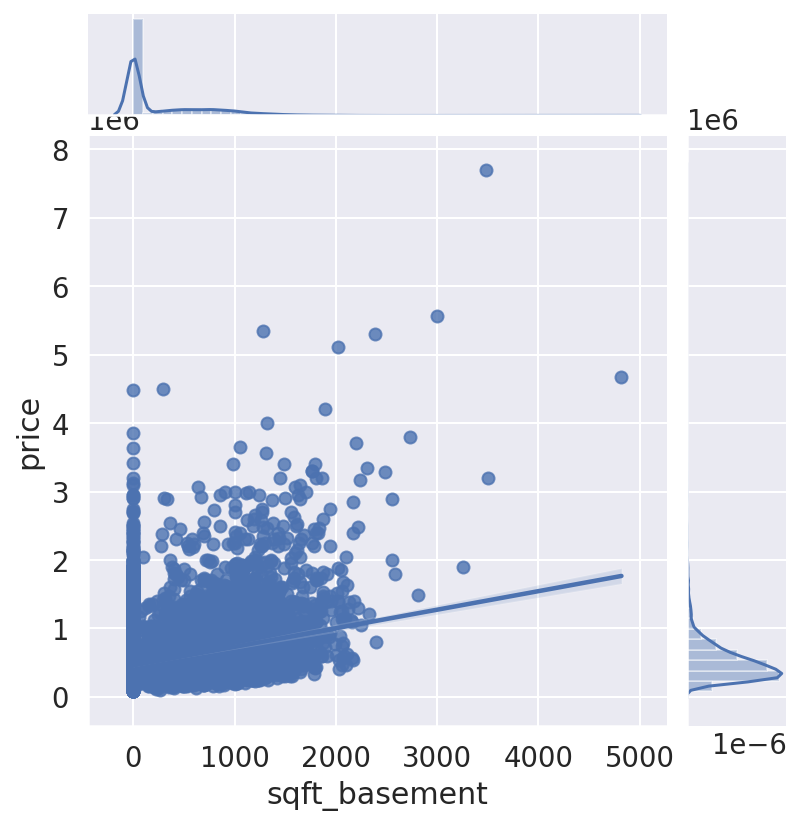

In [34]:
# Basement Area vs Sale Price (Before removing the outliers)
sns.jointplot(x=train['sqft_basement'], y=train['price'], kind='reg')

Here there aren't any much clearly visible outliers in the bottom right corner bu there are a few if them in the top left corner. We do remove them manually.

In [0]:
# Removing outliers manually (One point in the top left)
train = train.drop(train[(train['sqft_basement']<100) 
                         & (train['price']<5000000)].index).reset_index(drop=True)

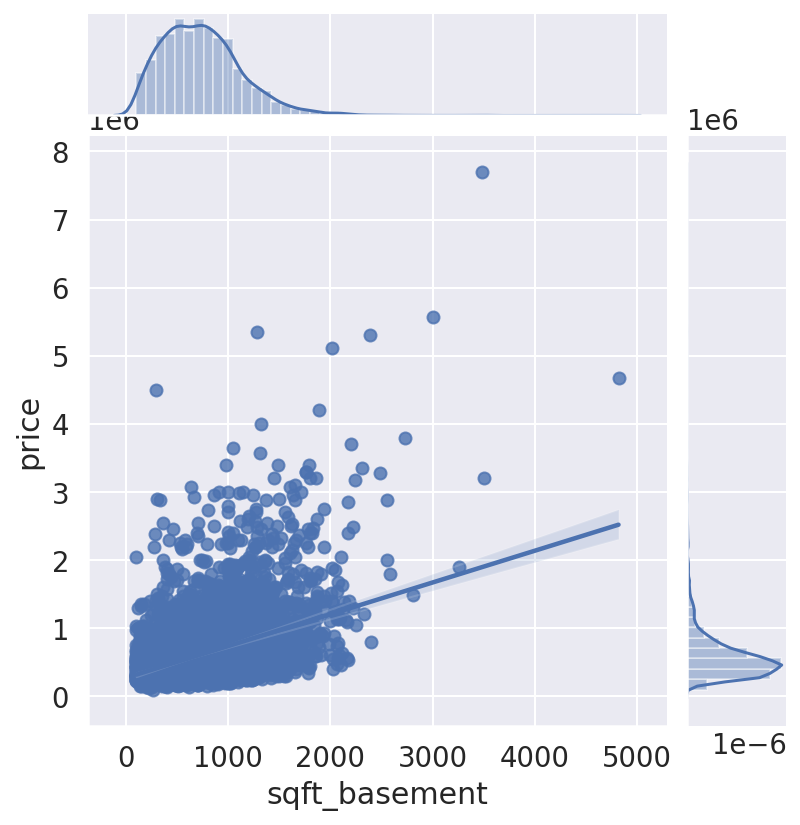

In [36]:
# Basement Area vs Sale Price (After removing the outliers)
sns.jointplot(x=train['sqft_basement'], y=train['price'], kind='reg')

9.1.lat (latitude) (Numerical Variable)

---
Latitude is a special case of numerical variabe in which it is spread over a specific range of values. So we have to deal with it in a special manner.

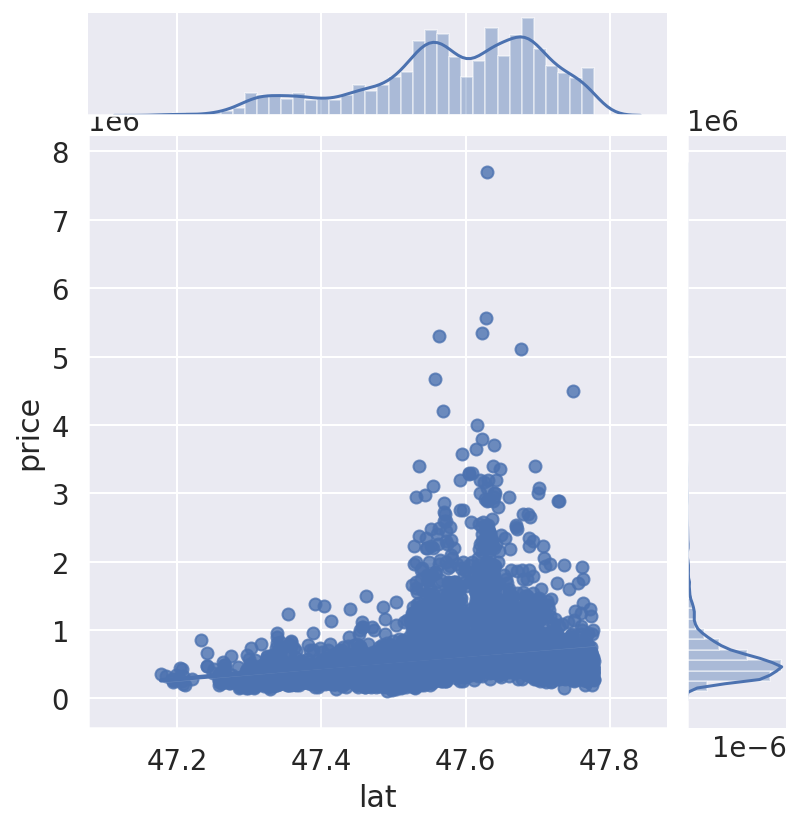

In [37]:
# Latidude vs Sale Price
sns.jointplot(x=train['lat'], y=train['price'], kind='reg')

Here we could observe that all the latitudes are within a certain range so let's make a categorical variable for a specific range of latitude.

In [0]:
train.loc[(train['lat'] >= 47.1) & (train['lat'] < 47.3), 'lat(47.1-47.3)'] = 1  
train.loc[(train['lat'] < 47.1) & (train['lat'] >= 47.3), 'lat(47.1-47.3)'] = 0 

train.loc[(train['lat'] >= 47.3) & (train['lat'] < 47.5), 'lat(47.3-47.5)'] = 1  
train.loc[(train['lat'] < 47.3) & (train['lat'] >= 47.5), 'lat(47.3-47.5)'] = 0

train.loc[(train['lat'] >= 47.5) & (train['lat'] < 47.7), 'lat(47.5-47.7)'] = 1  
train.loc[(train['lat'] < 47.5) & (train['lat'] >= 47.7), 'lat(47.5-47.7)'] = 0 

train.loc[(train['lat'] >= 47.7) & (train['lat'] < 47.9), 'lat(47.7-47.9)'] = 1  
train.loc[(train['lat'] < 47.7) & (train['lat'] >= 47.9), 'lat(47.7-47.9)'] = 0 

In [0]:
test.loc[(test['lat'] >= 47.1) & (test['lat'] < 47.3), 'lat(47.1-47.3)'] = 1  
test.loc[(test['lat'] < 47.1) & (test['lat'] >= 47.3), 'lat(47.1-47.3)'] = 0 

test.loc[(test['lat'] >= 47.3) & (test['lat'] < 47.5), 'lat(47.3-47.5)'] = 1  
test.loc[(test['lat'] < 47.3) & (test['lat'] >= 47.5), 'lat(47.3-47.5)'] = 0

test.loc[(test['lat'] >= 47.5) & (test['lat'] < 47.7), 'lat(47.5-47.7)'] = 1  
test.loc[(test['lat'] < 47.5) & (test['lat'] >= 47.7), 'lat(47.5-47.7)'] = 0 

test.loc[(test['lat'] >= 47.7) & (test['lat'] < 47.9), 'lat(47.7-47.9)'] = 1  
test.loc[(test['lat'] < 47.7) & (test['lat'] >= 47.9), 'lat(47.7-47.9)'] = 0 

9.2.long (longitude)

---
We do apply same logic as we did it in the case of latitude here.


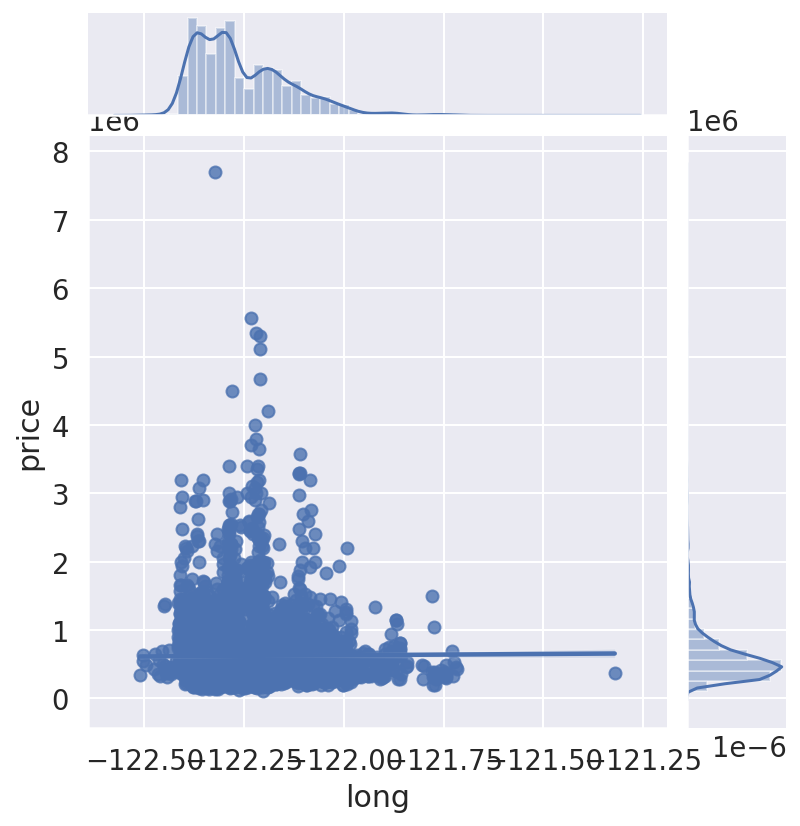

In [40]:
# Longitude vs Sale Price
sns.jointplot(x=train['long'], y=train['price'], kind='reg')

In [0]:
train.loc[(train['long'] >= -122.75) & (train['long'] < -122.25), 'long((-122.75)-(-122.25))'] = 1  
train.loc[(train['long'] < -122.75) & (train['long'] >= -122.25), 'long((-122.75)-(-122.25))'] = 0 

train.loc[(train['long'] >= -122.25) & (train['long'] < -121.75), 'long((-122.25)-(-121.75))'] = 1  
train.loc[(train['long'] < -122.25) & (train['long'] >= -121.75), 'long((-122.25)-(-121.75))'] = 0 

train.loc[(train['long'] >= -121.75) & (train['long'] < -121.25), 'long((-121.75)-(-121.25))'] = 1  
train.loc[(train['long'] < -121.75) & (train['long'] >= -121.25), 'long((-121.75)-(-121.25))'] = 0 

In [0]:
test.loc[(test['long'] >= -122.75) & (test['long'] < -122.25), 'long((-122.75)-(-122.25))'] = 1  
test.loc[(test['long'] < -122.75) & (test['long'] >= -122.25), 'long((-122.75)-(-122.25))'] = 0 

test.loc[(test['long'] >= -122.25) & (test['long'] < -121.75), 'long((-122.25)-(-121.75))'] = 1  
test.loc[(test['long'] < -122.25) & (test['long'] >= -121.75), 'long((-122.25)-(-121.75))'] = 0 

test.loc[(test['long'] >= -121.75) & (test['long'] < -121.25), 'long((-121.75)-(-121.25))'] = 1  
test.loc[(test['long'] < -121.75) & (test['long'] >= -121.25), 'long((-121.75)-(-121.25))'] = 0 

10.bedrooms (Categorical variable)

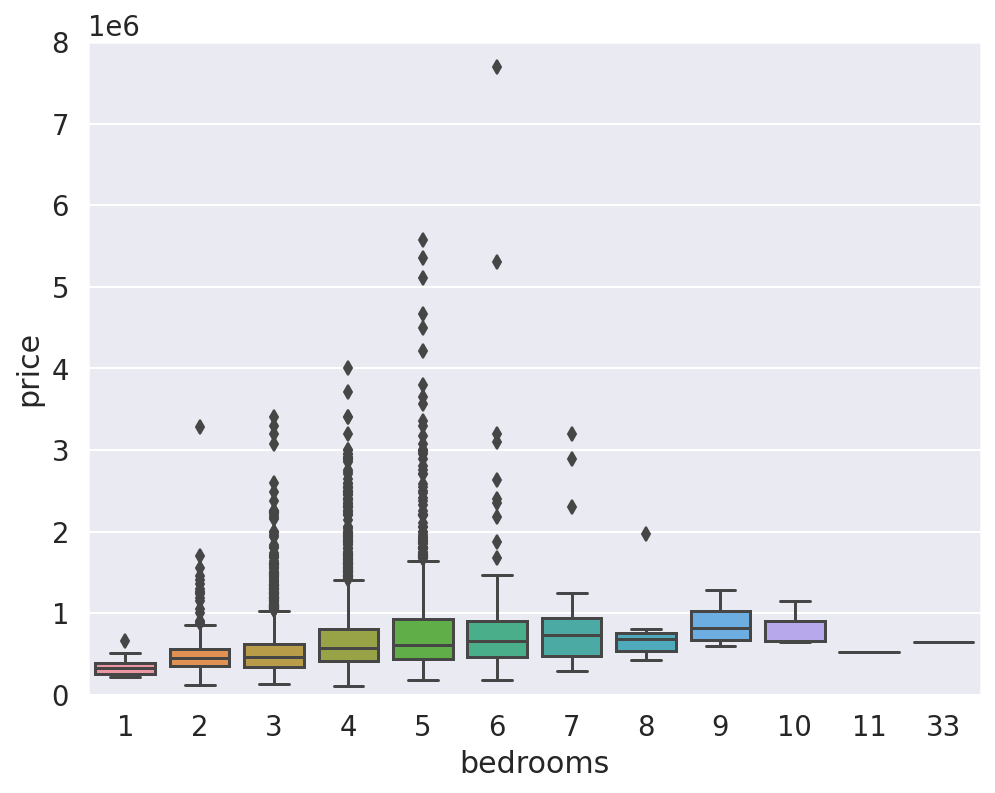

In [43]:
# Bedrooms vs Sale Price (Before removing Outliers)
var = 'bedrooms'
data = pd.concat([train['price'] ,train[var]], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);

There is nothing much to get excited after looking at the above boxplot. People do usually pay more for more bedrroms. But the point to be noted is that the bedrooms with more than 10 bedrooms. Those houses with such huge number of bedrooms will surely be a problem in the modelling and prediction process and  so we treat them as outliers and remove them manually.

In [0]:
# Removing outliers manually (More than 10-bedrooms)
train = train.drop(train[(train['bedrooms']>10)].index).reset_index(drop=True)

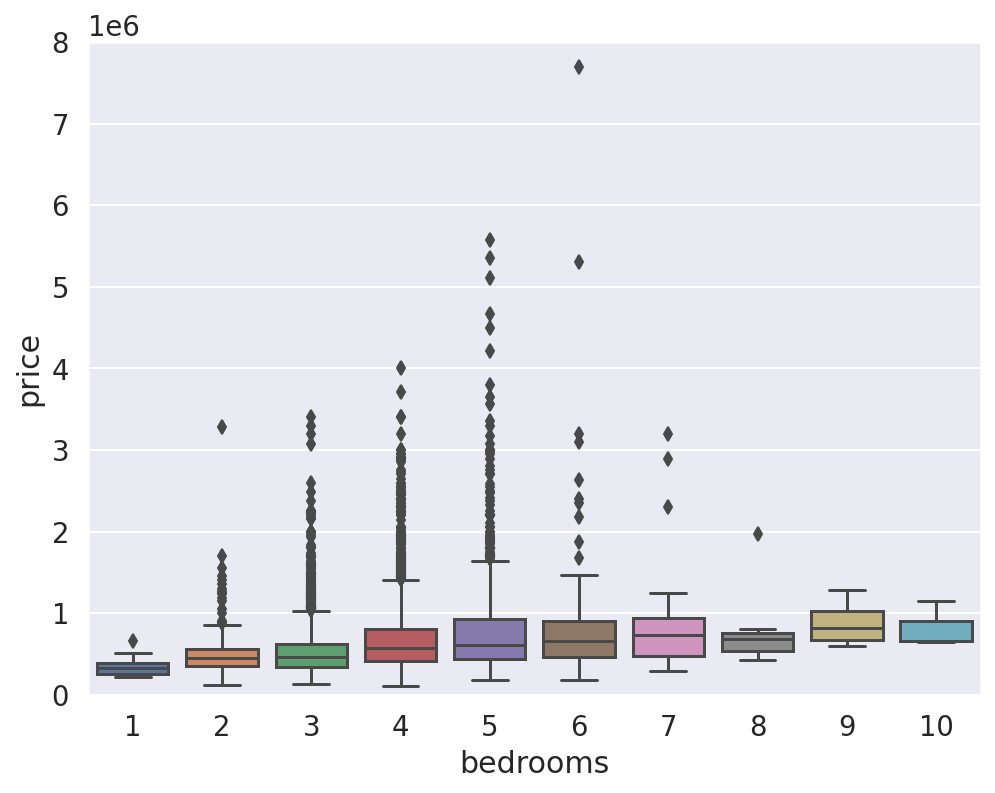

In [45]:
# Bedrooms vs Sale Price (After removing Outliers)
var = 'bedrooms'
data = pd.concat([train['price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);

11.Waterfront (Categorical variable)

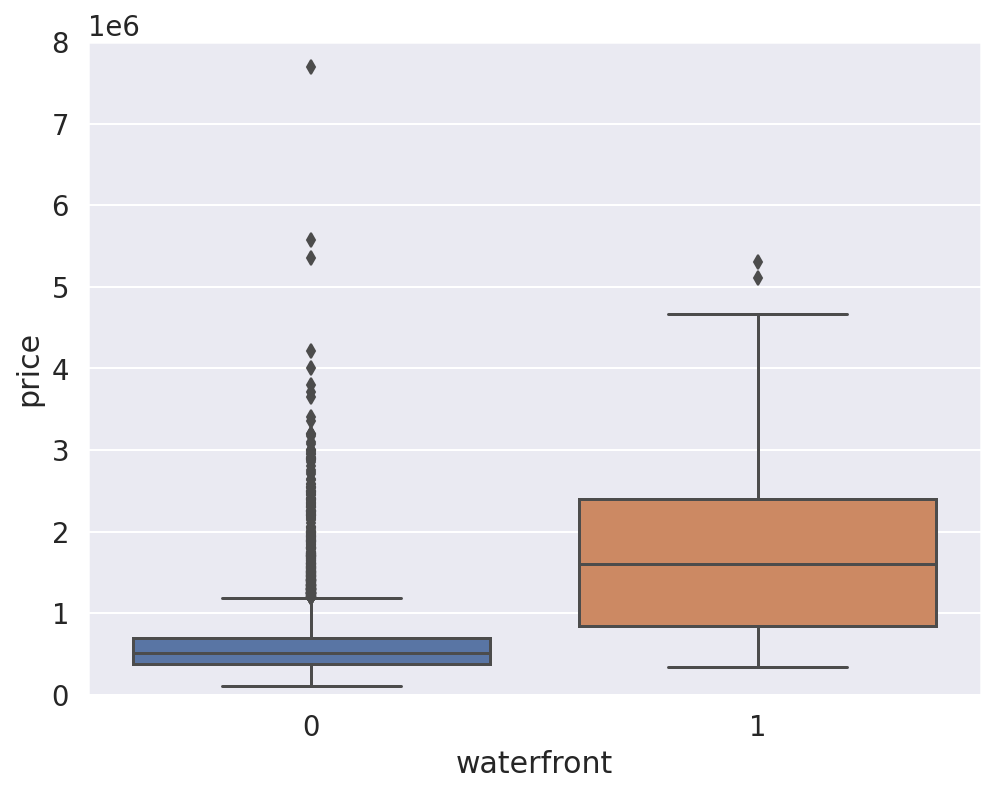

In [46]:
# waterfront vs Sale Price
var = 'waterfront'
data = pd.concat([train['price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);

There is nothing much to be annoyed about the above plot. People pay more for houses that do have a waterfront.

12.floors (Categorical variable)

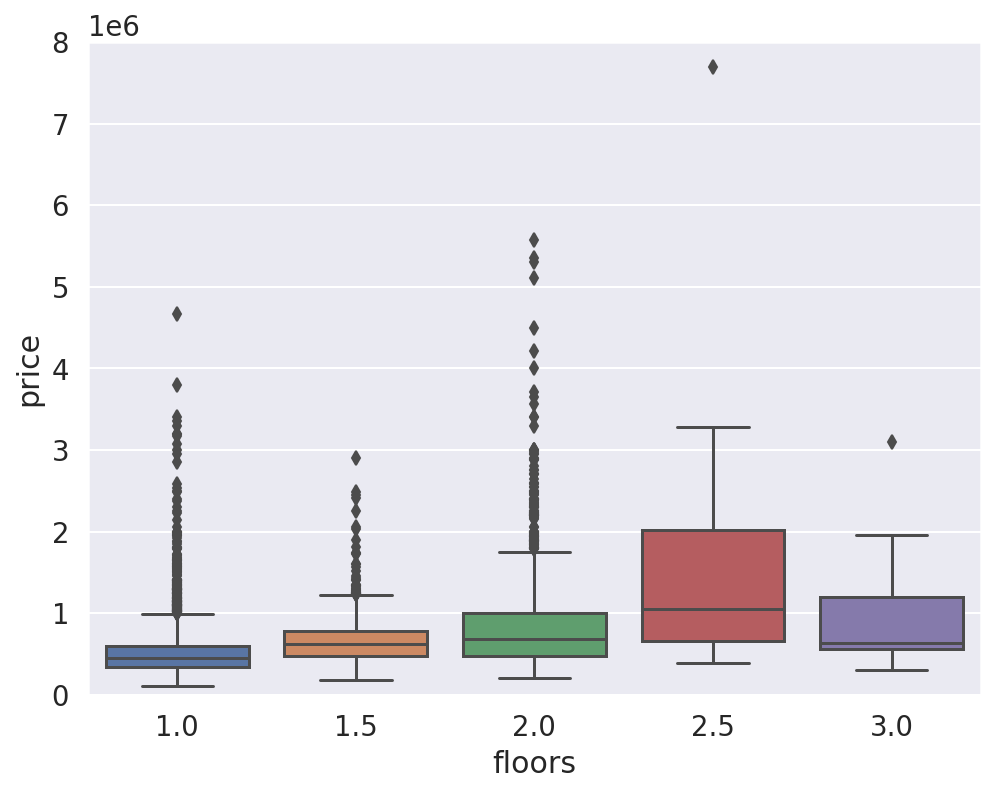

In [47]:
# Floors vs Sale Price (Before removing outliers)
var = 'floors'
data = pd.concat([train['price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);

There is really a important thing to be noted from the above plot. People usually ay more for more number of floors but why are the prices for the houses with 3 and 3.5 floors pretty much lower. These points will surely be a trouble in the modelling process. so we remove them as outliers.

In [0]:
# Removing outliers manually (More than 3-floors)
train = train.drop(train[(train['floors']>3) 
                         & (train['price']<3000000)].index).reset_index(drop=True)

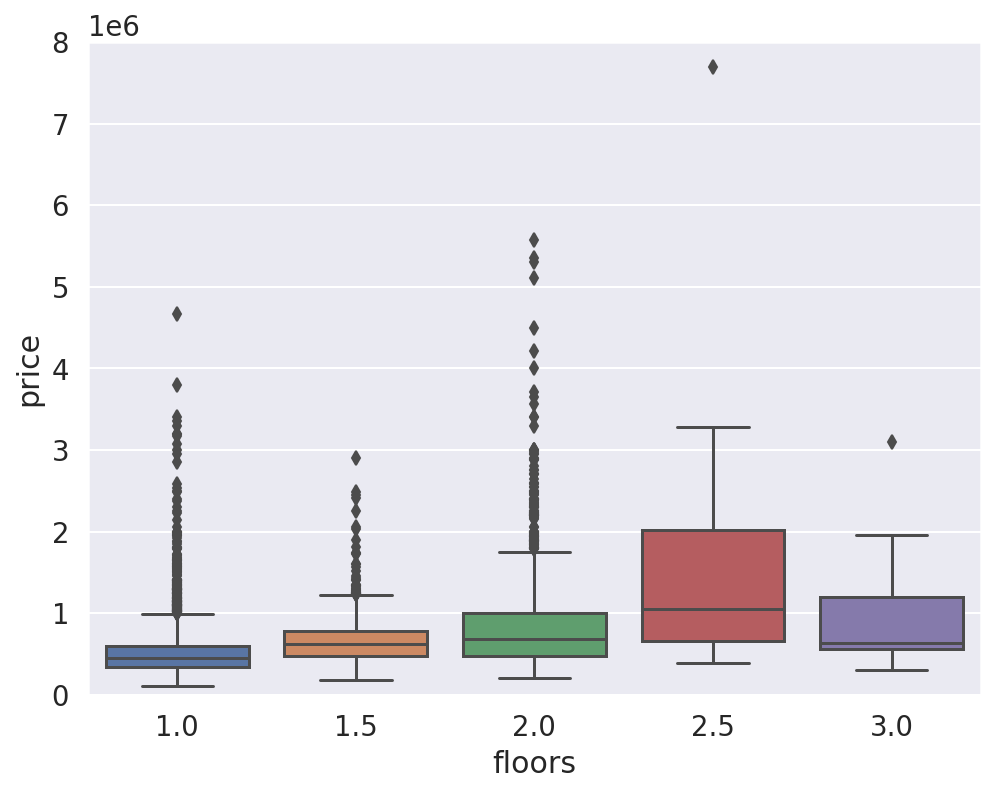

In [49]:
# Floors vs Sale Price (After removing Outliers)
var = 'floors'
data = pd.concat([train['price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);

13.yr_renovated (Numerical Variable)

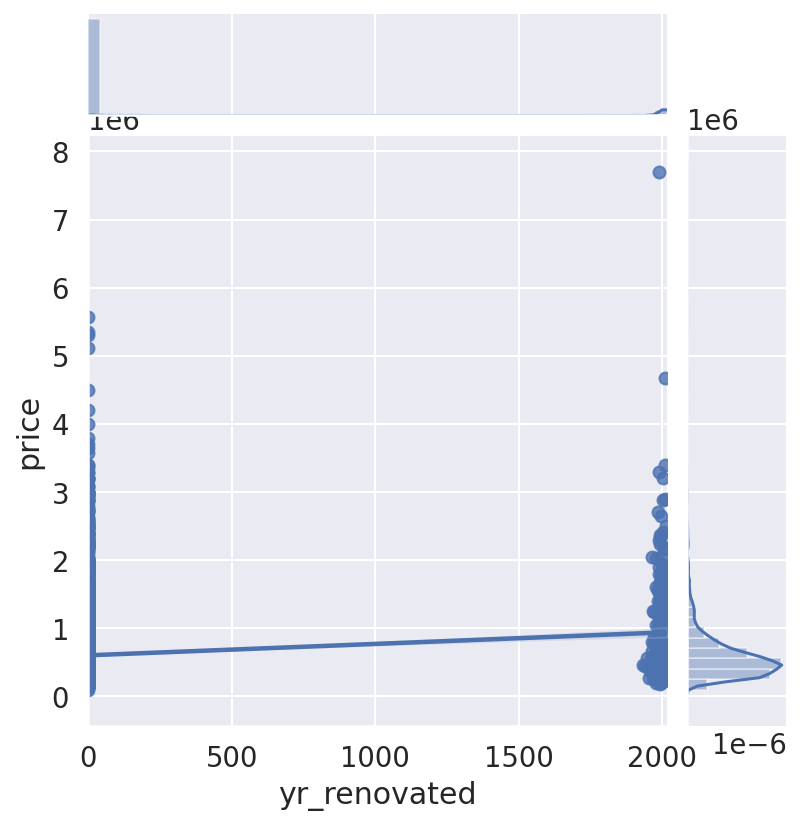

In [50]:
# Year_renovated vs Sale Price
sns.jointplot(x=train['yr_renovated'], y=train['price'], kind='reg')

This is also a special type of We could convert it here into two categories as either renovated or not renovated

In [0]:
train.loc[given_train_data['yr_renovated'] ==0, 'renovation'] =  0
train.loc[given_train_data['yr_renovated'] >0, 'renovation'] = 1

test.loc[given_pred_data['yr_renovated'] ==0, 'renovation'] =  0
test.loc[given_pred_data['yr_renovated'] >0, 'renovation'] = 1

14.house_area(Numerical Variable)

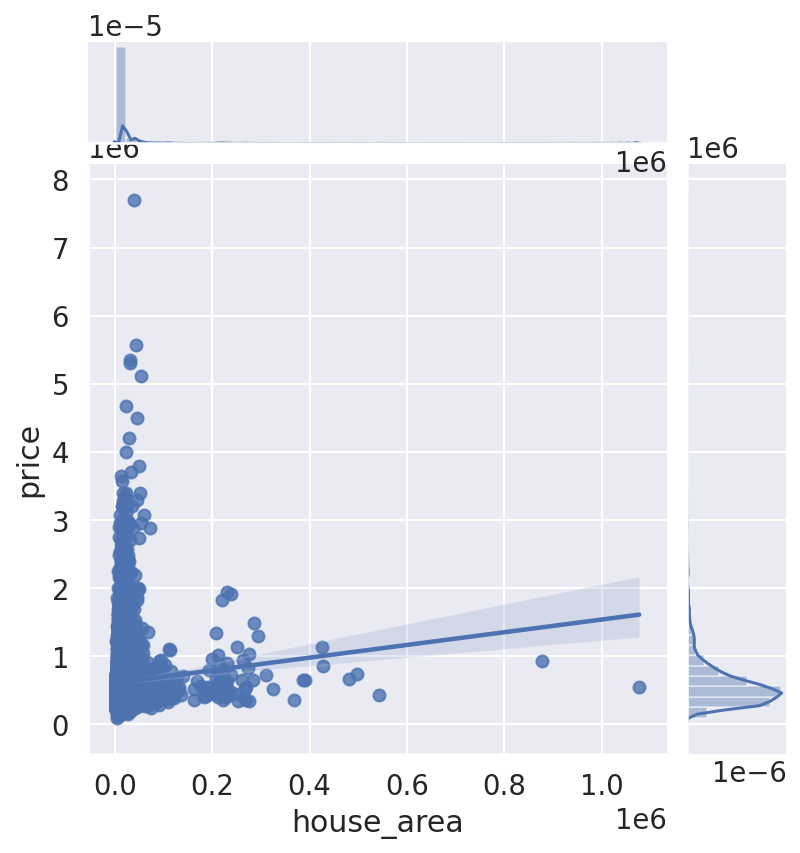

In [52]:
# house_area vs Sale Price
sns.jointplot(x=train['house_area'], y=train['price'], kind='reg')

Nothing pretty much to be noted here except those outliers at the top left and the bottom right.

In [0]:
# Removing outliers manually (One point in the bottom right)
train = train.drop(train[(train['house_area']>750000) 
                         & (train['price']<1100000)].index).reset_index(drop=True)

# Removing outliers manually (One point in the top left)
train = train.drop(train[(train['house_area']<100000) 
                         & (train['price']>4000000)].index).reset_index(drop=True)

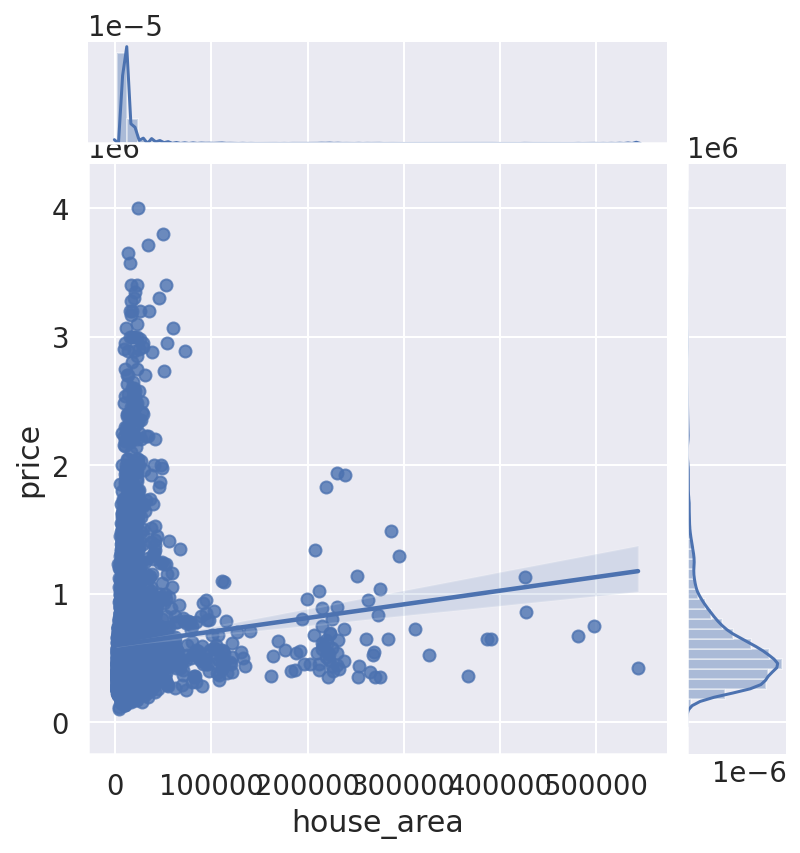

In [54]:
# house_area vs Sale Price
sns.jointplot(x=train['house_area'], y=train['price'], kind='reg')

15.house_area15(Numerical variable)

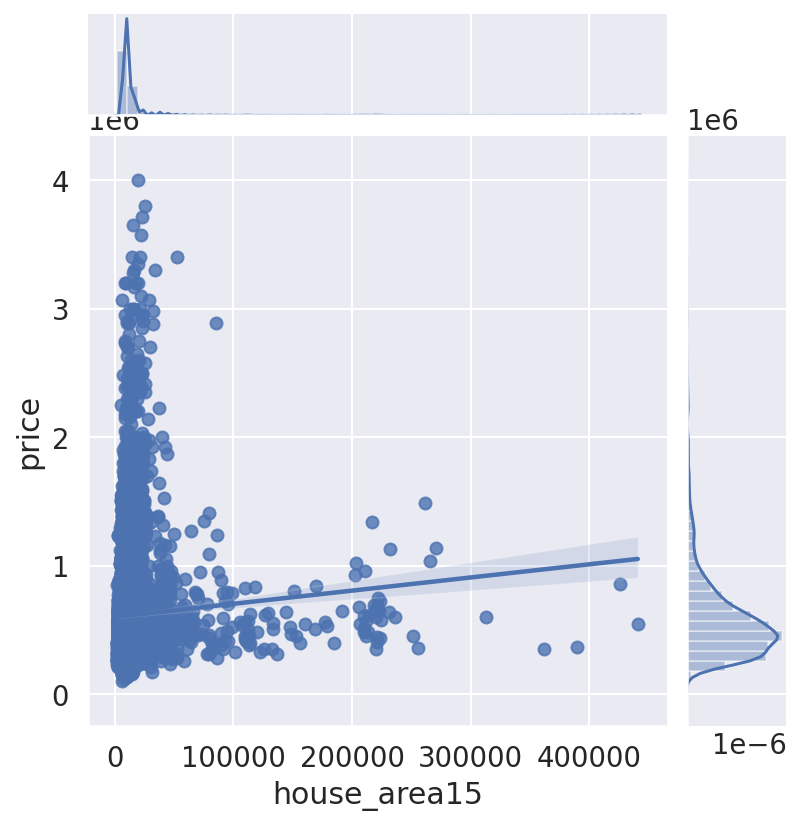

In [55]:
# house_area15 vs Sale Price
sns.jointplot(x=train['house_area15'], y=train['price'], kind='reg')

Here too we see the outliers and we remove them manaually.

In [0]:
# Removing outliers manually (One point in the bottom right)
train = train.drop(train[(train['house_area15']>400000) 
                         & (train['price']<1100000)].index).reset_index(drop=True)

train = train.drop(train[(train['house_area15']<20000) 
                         & (train['price']>4000000)].index).reset_index(drop=True)

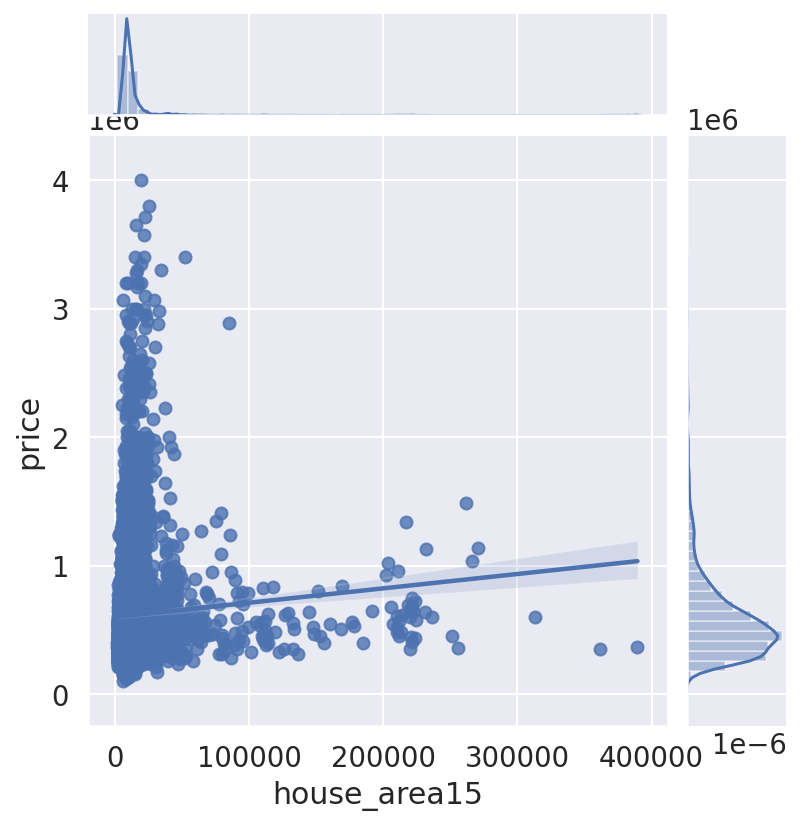

In [57]:
# house_area15 vs Sale Price
sns.jointplot(x=train['house_area15'], y=train['price'], kind='reg')

16.sqft_lot(Numerical Variable)

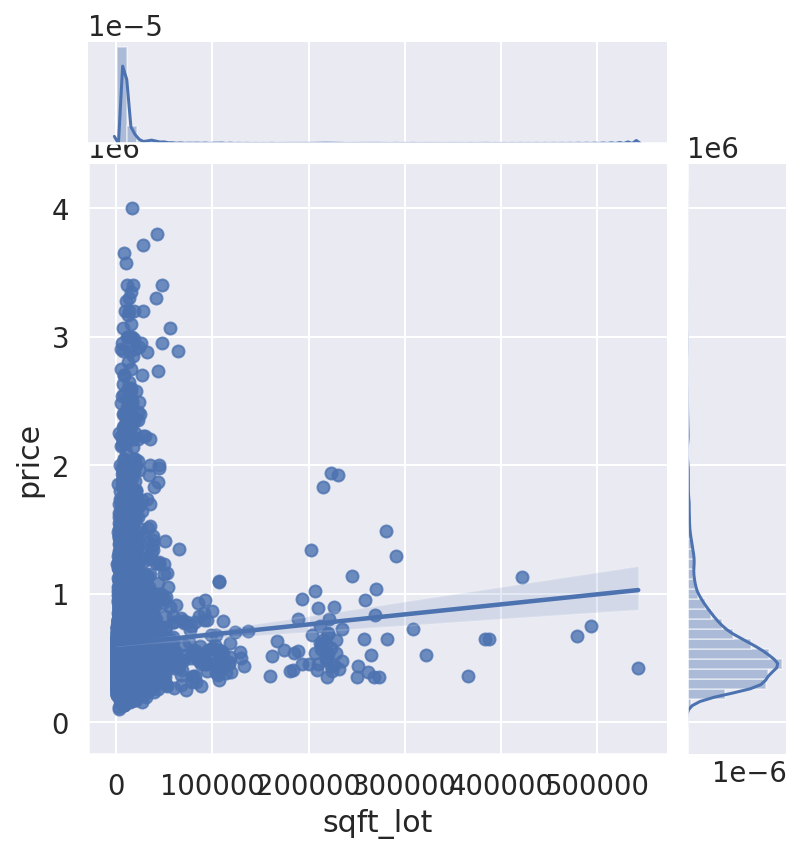

In [58]:
# sqft_lot vs Sale Price
sns.jointplot(x=train['sqft_lot'], y=train['price'], kind='reg')

Nothing new to be noted specially except those outliers which we remove manually.

In [0]:
# Removing outliers manually (One point in the bottom right)
train = train.drop(train[(train['sqft_lot']>500000) 
                         & (train['price']<2200000)].index).reset_index(drop=True)

# Removing outliers manually (One point in the top left)
train = train.drop(train[(train['sqft_lot']<200000) 
                         & (train['price']>5000000)].index).reset_index(drop=True)                       

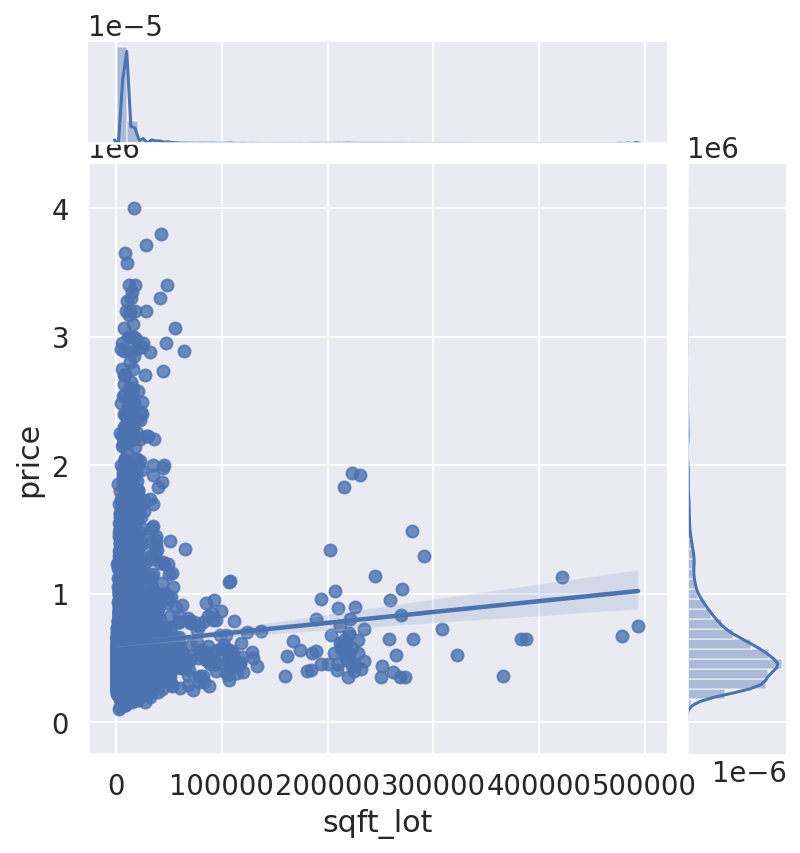

In [60]:
# sqft_lot vs Sale Price
sns.jointplot(x=train['sqft_lot'], y=train['price'], kind='reg')

17.free_area (Numerical Variable)

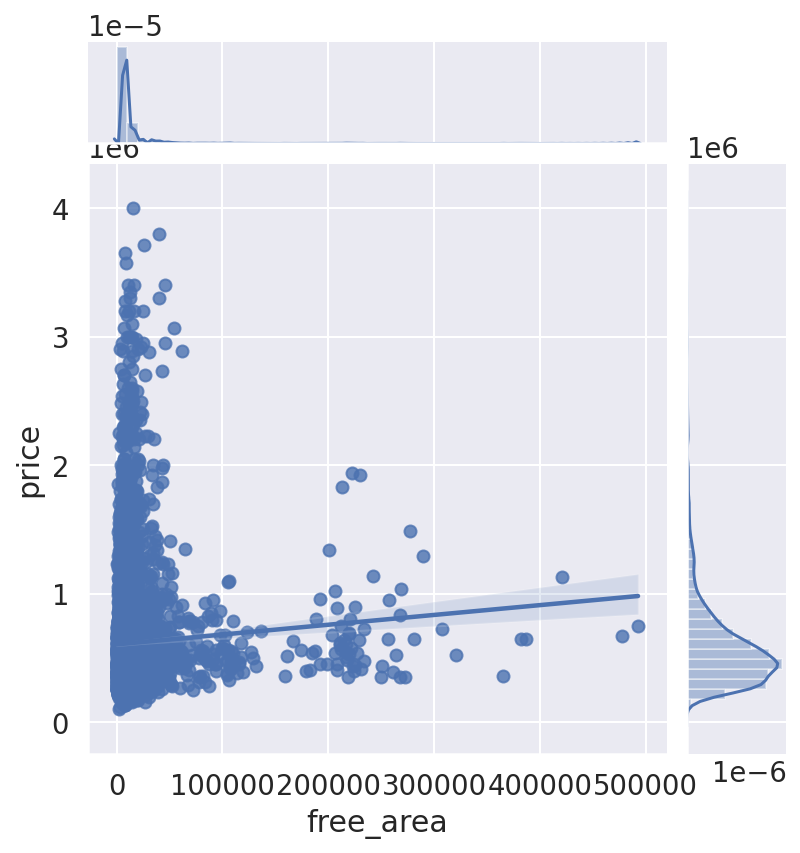

In [61]:
# free_area vs Sale Price
sns.jointplot(x=train['free_area'], y=train['price'], kind='reg')

18.sqft_lot15 (Numerical variable)

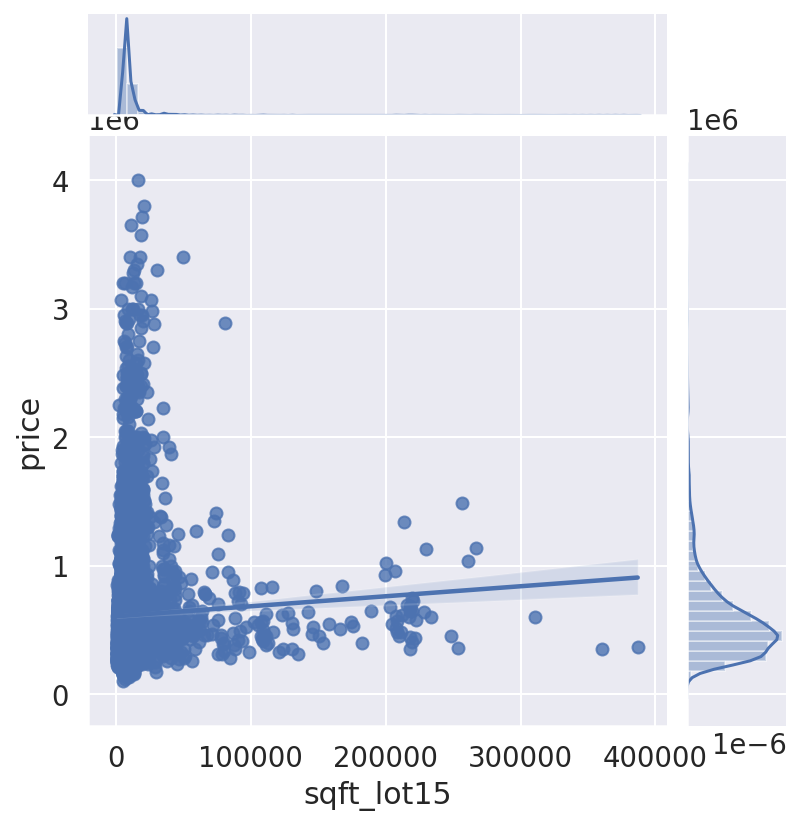

In [62]:
# sqft_lot15 vs Sale Price
sns.jointplot(x=train['sqft_lot15'], y=train['price'], kind='reg')

Here we encounter the outliers at the bottom right and the top left. We tend to remove them manually.

In [0]:
# Removing outliers manually (One point in the bottom right)
train = train.drop(train[(train['sqft_lot15']>300000) 
                         & (train['price']<1000000)].index).reset_index(drop=True)

# Removing outliers manually (One point in the bottom right)
train = train.drop(train[(train['sqft_lot15']<200000) 
                         & (train['price']>3900000)].index).reset_index(drop=True)                       

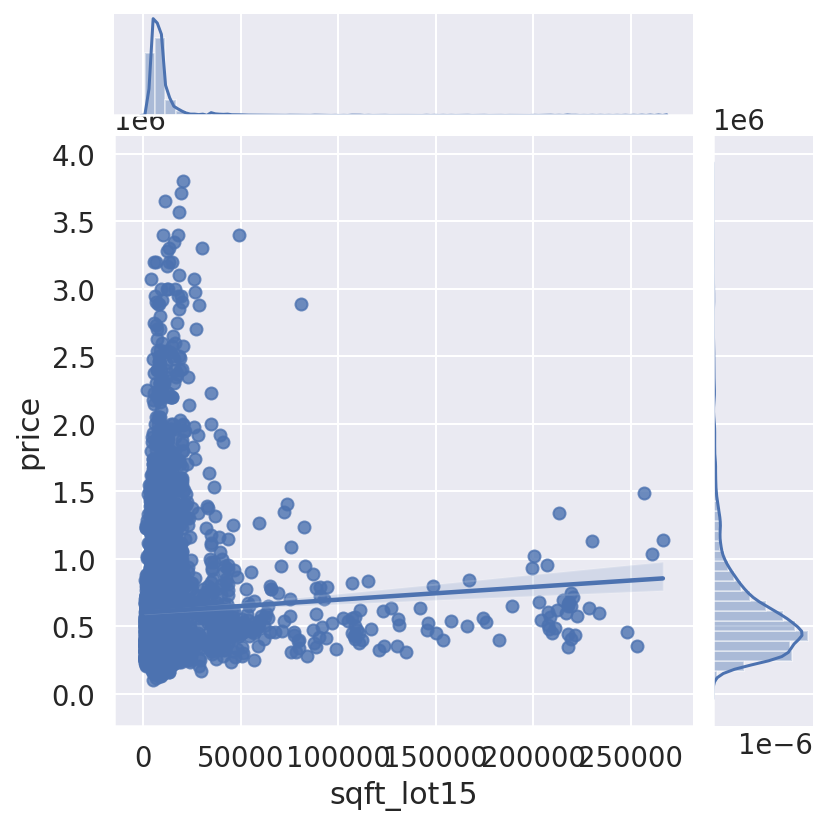

In [64]:
# sqft_lot15 vs Sale Price
sns.jointplot(x=train['sqft_lot15'], y=train['price'], kind='reg')

Zipcode (Adding new features)

---
Now we take a look at the feature of the zipcode which we haven't looked upon yet and so we now observe the feature.

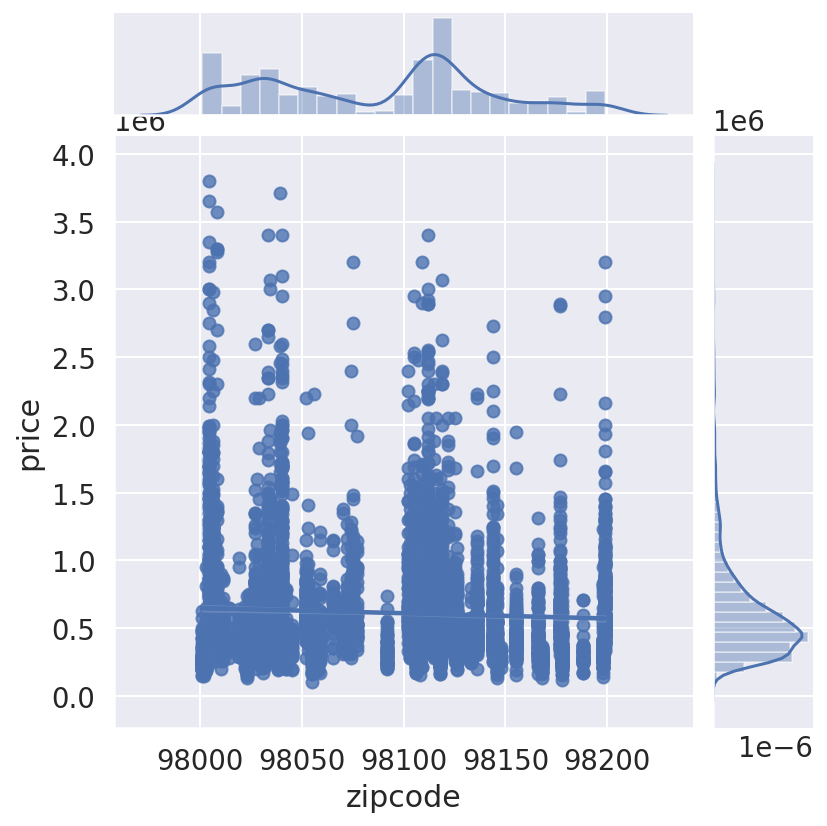

In [65]:
# Zipcode vs Sale Price
sns.jointplot(x=train['zipcode'], y=train['price'], kind='reg')

Looking carefully at the above plot we could see explicitly that the values of zipcode are looking clustered into some groups and we now group them and create new categorical feature based on the grouping.

In [0]:
train.loc[(train['zipcode'] >= 98000) & (train['zipcode'] < 98025), 'zipcode(98000-98025)'] = 1     

train.loc[(train['zipcode'] >= 98025) & (train['zipcode'] < 98050), 'zipcode(98025-98050)'] = 1  

train.loc[(train['zipcode'] >= 98050) & (train['zipcode'] < 98075), 'zipcode(98050-98075)'] = 1  

train.loc[(train['zipcode'] >= 98075) & (train['zipcode'] < 98100), 'zipcode(98075-98100)'] = 1  

train.loc[(train['zipcode'] >= 98100) & (train['zipcode'] < 98125), 'zipcode(98100-98125)'] = 1  

train.loc[(train['zipcode'] >= 98125) & (train['zipcode'] < 98150), 'zipcode(98125-98150)'] = 1  

train.loc[(train['zipcode'] >= 98150) & (train['zipcode'] < 98175), 'zipcode(98150-98175)'] = 1  

train.loc[(train['zipcode'] >= 98175) & (train['zipcode'] < 98200), 'zipcode(98175-98200)'] = 1  

In [0]:
test.loc[(test['zipcode'] >= 98000) & (test['zipcode'] < 98025), 'zipcode(98000-98025)'] = 1  

test.loc[(test['zipcode'] >= 98025) & (test['zipcode'] < 98050), 'zipcode(98025-98050)'] = 1  

test.loc[(test['zipcode'] >= 98050) & (test['zipcode'] < 98075), 'zipcode(98050-98075)'] = 1  

test.loc[(test['zipcode'] >= 98075) & (test['zipcode'] < 98100), 'zipcode(98075-98100)'] = 1  

test.loc[(test['zipcode'] >= 98100) & (test['zipcode'] < 98125), 'zipcode(98100-98125)'] = 1  

test.loc[(test['zipcode'] >= 98125) & (test['zipcode'] < 98150), 'zipcode(98125-98150)'] = 1  

test.loc[(test['zipcode'] >= 98150) & (test['zipcode'] < 98175), 'zipcode(98150-98175)'] = 1  

test.loc[(test['zipcode'] >= 98175) & (test['zipcode'] < 98200), 'zipcode(98175-98200)'] = 1  

We have groupe dthem into certain range and made seperate new features for the indiavual grouping.

There might be some missing features in the dataset and we fill them all with zeroes.

In [0]:
train=train.fillna(0)
test=test.fillna(0)

Now let's have a look at the dataset again.

In [69]:
train.head()

,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sale,month_sale,date_sale,day_sale,land_area,house_area,house_area15,free_area,free_area15,bed_area,floor_area,log_price,lat(47.1-47.3),lat(47.3-47.5),lat(47.5-47.7),lat(47.7-47.9),long((-122.75)-(-122.25)),long((-122.25)-(-121.75)),long((-121.75)-(-121.25)),renovation,zipcode(98000-98025),zipcode(98025-98050),zipcode(98050-98075),zipcode(98075-98100),zipcode(98100-98125),zipcode(98125-98150),zipcode(98150-98175),zipcode(98175-98200)
0,538000.0,3,2570,7242,2.0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9,1,2570,9812,9329,6842,7239,856.666667,1285.0,13.195616,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,604000.0,4,1960,5000,1.0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9,1,1960,6960,6360,4090,4090,490.000000,1960.0,13.311331,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,229500.0,3,1780,7470,1.0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113,2015,4,15,2,1780,9250,9893,6740,7383,593.333333,1780.0,12.343663,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,662500.0,3,3560,9796,1.0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925,2015,4,3,4,3560,13356,11135,8096,7225,1186.666667,3560.0,13.403777,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,468000.0,2,1160,6000,1.0,0,4,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000,2014,5,27,1,1160,7160,7330,5700,5700,580.000000,1160.0,13.056226,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Again looking at the correlation matrix after adding certain new features.

In [70]:
corrmat=train.corr()
corr_val=corrmat['price']
corr_val

price                        1.000000
bedrooms                     0.249794
sqft_living                  0.697987
sqft_lot                     0.058135
floors                       0.368628
waterfront                   0.276860
condition                    0.083370
grade                        0.700959
sqft_above                   0.693009
sqft_basement                0.397364
yr_built                    -0.009566
yr_renovated                 0.173434
zipcode                     -0.052763
lat                          0.263077
long                         0.008785
sqft_living15                0.611365
sqft_lot15                   0.046586
year_sale                    0.011691
month_sale                  -0.017316
date_sale                   -0.023388
day_sale                     0.008658
land_area                    0.697987
house_area                   0.080662
house_area15                 0.065932
free_area                    0.052557
free_area15                  0.039004
bed_area    

In [0]:
#Here we assigning the traing variable (target_variable)
y_train=train['price']
#We also do a log transform here to our target variable
y_train_log=train['log_price']

An important point to be noted is that when we do apply log_transform and use them as a feature to model our data, we need to do the inverse log transform (i.e) do compute the exponent at the last after the prediction.

After looking at the above Correlation matrix we drop certain columns that do have negative correlation.

In [0]:
X_train=train.drop(columns=['log_price','price','zipcode','month_sale','date_sale','lat(47.1-47.3)','lat(47.3-47.5)','lat(47.7-47.9)','long((-122.75)-(-122.25))','long((-121.75)-(-121.25))','renovation','zipcode(98025-98050)','zipcode(98050-98075)','zipcode(98125-98150)','zipcode(98150-98175)','zipcode(98175-98200)'])

In [0]:
X_test=test.drop(columns=['zipcode','month_sale','date_sale','lat(47.1-47.3)','lat(47.3-47.5)','lat(47.7-47.9)','long((-122.75)-(-122.25))','long((-121.75)-(-121.25))','renovation','zipcode(98025-98050)','zipcode(98050-98075)','zipcode(98125-98150)','zipcode(98150-98175)','zipcode(98175-98200)'])

In [74]:
X_train.columns

Index(['bedrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'year_sale', 'day_sale', 'land_area', 'house_area', 'house_area15',
       'free_area', 'free_area15', 'bed_area', 'floor_area', 'lat(47.5-47.7)',
       'long((-122.25)-(-121.75))', 'zipcode(98000-98025)',
       'zipcode(98075-98100)', 'zipcode(98100-98125)'],
      dtype='object')

In [75]:
X_test.columns

Index(['bedrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'year_sale', 'day_sale', 'land_area', 'house_area', 'house_area15',
       'free_area', 'free_area15', 'bed_area', 'floor_area', 'lat(47.5-47.7)',
       'long((-122.25)-(-121.75))', 'zipcode(98000-98025)',
       'zipcode(98075-98100)', 'zipcode(98100-98125)'],
      dtype='object')

We once again look at the columns of the training and the testing dataset to make sure that the columns in both of them are the same

**MODEL SELECTION**

Now we enter into next part of our solution which is the model selection and prediction process.

**MODEL-1**
This model uses the HistGradientBoost Regressor along with the CV algorithm


**Note:**
After going through various kinds of regressor and then using them to predict the model and check the accuracy we finally arrive at the case of this model of HistGradientBoost regressor a much faster and efficient regressor.

In [0]:
numeric_features = X_train.columns #seperate the list of numeric features
numeric_transformer = make_pipeline(StandardScaler()) 
#use make_pipeline method to create a simple pipeline of the StandardScaler transformer
Preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
hgb_pipe = make_pipeline(Preprocessor,
                         HistGradientBoostingRegressor())
#we then make a seperate pipeline for the model

Now we then use our other techniques such as Cross_validation to improve the efficiency of the model further. In this case i have used a 5 fold cross validation to tune the hyperparameters for this regressor.

In this case I have used the log transformed target variable and so at the end after the prediction process we exponentiate them to arrive the output

In [77]:
#parameters to tune
parameters = {'histgradientboostingregressor__max_iter' : [300,400,500,600],
 'histgradientboostingregressor__learning_rate' : [0.1,0.3,0.5,0.6,0.9],
 'histgradientboostingregressor__max_depth' : [30,40,50],
 'histgradientboostingregressor__l2_regularization' : [1,1.5,2,2.5],
 'histgradientboostingregressor__scoring' : ['r2'],
 'histgradientboostingregressor__warm_start' : [True,False],
 'histgradientboostingregressor__random_state' : [2019,2020],
 }
#instantiate the gridsearch
hgb_grid = GridSearchCV(hgb_pipe, parameters, n_jobs=5, 
 cv=5, scoring='r2',
 verbose=2, refit=True)
#fit on the grid 
hgb_grid.fit(X_train, y_train_log)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   58.7s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed: 11.7min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 21.1min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed: 32.7min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed: 47.8min
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed: 64.6min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed: 84.9min
[Parallel(n_jobs=5)]: Done 3271 tasks      | elapsed: 107.4min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 132.7min
[Parallel(n_jobs=5)]: Done 4800 out of 4800 | elapsed: 157.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                           

The above process which is running actually takes about 50 mins to complete it and hence I can't wait till then to show the output but that's the model.

By using a 5 fold cross validation I have found the best model and here below we print the corresponding parameters.

In [78]:
# Print the best parameters found
print(hgb_grid.best_params_)
# Print the best scores found
print()
print(hgb_grid.best_score_)

{'histgradientboostingregressor__l2_regularization': 1, 'histgradientboostingregressor__learning_rate': 0.1, 'histgradientboostingregressor__max_depth': 30, 'histgradientboostingregressor__max_iter': 300, 'histgradientboostingregressor__random_state': 2019, 'histgradientboostingregressor__scoring': 'r2', 'histgradientboostingregressor__warm_start': True}

0.8886331387964574


Using the best model that we have obtained ny using GridSearchCV, we will now predict our test dataset.

In [0]:
#applying exponential after the prediction to cancel out the log transform done earlier
y_pred_hgb_log = np.expm1(hgb_grid.predict(X_test))

There are also few other model that I have tried but they take a much longer time to run and also their accuracy is not pretty much good.

**MODEL-2**
Simple XGB Regressor

In [0]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)

In [0]:
model_xgb.fit(X_train, y_train_log)
xgb_train_pred = model_xgb.predict(X_train)
pred_out = np.expm1(model_xgb.predict(X_test))
#pred_out= model_xgb.predict(X_test)

**MODEL-3** 
Simple HistGradientBoost Regressor


---

This is the very simple and basic model of the HistGradientBoost Regressor

In [0]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
hgdb_reg=HistGradientBoostingRegressor(loss='least_squares', learning_rate=0.1, max_iter=600, max_leaf_nodes=40, max_depth=None, min_samples_leaf=20, l2_regularization=100, max_bins=255, warm_start=True, scoring=None, validation_fraction=0.3, n_iter_no_change=None, tol=1e-07, verbose=0, random_state=None)
hgdb_reg.fit(X_train,y_train_log)
pred_out=np.expm1(hgdb_reg.predict(X_test))
#hgdb_reg.get_params()

**MODEL-5**
Simple Extra Trees Regressor

In [0]:
from sklearn.ensemble import ExtraTreesRegressor
etr_reg=ExtraTreesRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
etr_reg.fit(X_train,y_train_log)
pred_out=np.expm1(etr_reg.predict(X_test))

 **MODEL-6** 
Ensembling Methods


---

This ensembling method was actually taken from other similar problem and I haven't written this model on my own. I have just used it and it took hours to run and I left it as such.

In [0]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [0]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [0]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [0]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [0]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

##score = rmsle_cv(stacked_averaged_models)
##print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [0]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [0]:
#Stacked Models
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
#print(rmsle(y_train, stacked_train_pred))

In [0]:
#XGBoost
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
#print(rmsle(y_train, xgb_train_pred))

In [0]:
#LGB Regressor
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
#print(rmsle(y_train, lgb_train_pred))

In [0]:
#LGB Regressor
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
#print(rmsle(y_train, lgb_train_pred))

In [0]:
# Example
Stacked = 1/(0.1077)
XGBoost = 1/(0.1177)
LGBM = 1/(0.1159)
Sum = Stacked + XGBoost + LGBM
Stacked = Stacked/Sum
XGBoost = XGBoost/Sum
LGBM = LGBM/Sum
print(Stacked, XGBoost, LGBM)

In [0]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*Stacked +
               xgb_train_pred*XGBoost + lgb_train_pred*LGBM))

In [0]:
ensemble = stacked_pred*Stacked + xgb_pred*XGBoost + lgb_pred*LGBM

 **Writing to OUTPUT File**

In [0]:
out=pd.DataFrame(data=y_pred_hgb_log,columns=['price'])
out['id']=pred_ID
out.to_csv('prediction_y_pred_hgb_log.csv', index=False)